In [3]:
#importing libraries

import numpy as np
import pandas as pd
import earthpy.plot as ep
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
#loading datasets
pines = loadmat("C:/Users/Sobhan/Machine Learning/satellite/indian_pines/Indian_pines_corrected.mat")["indian_pines_corrected"]
groundtruth = loadmat("C:/Users/Sobhan/Machine Learning/satellite/indian_pines/Indian_pines_gt.mat")["indian_pines_gt"]


In [9]:
df = pd.DataFrame(pines.reshape(pines.shape[0]*pines.shape[1], -1))

df.columns = [f"band{i}" for i in range(1, df.shape[-1]+1)]

df["class"] = groundtruth.ravel()

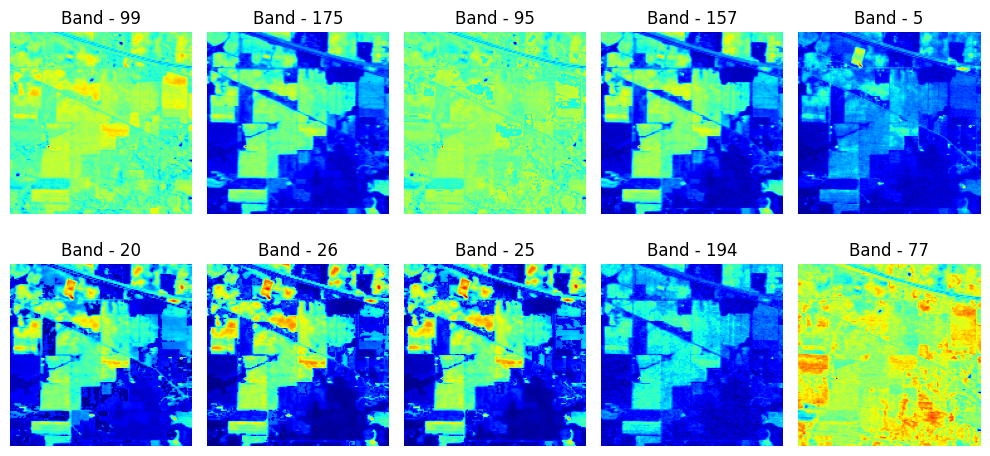

In [10]:
#visualizing the bands

fig = plt.figure(figsize = (10, 5))

ax = fig.subplots(2, 5)

for i in range(2):
    for j in range(5):
        c = np.random.randint(200)
        ax[i][j].imshow(pines[:, :, c], cmap = "jet")
        ax[i][j].axis("off")
        ax[i][j].title.set_text(f"Band - {c}")
        c+=1

plt.tight_layout()

plt.show()

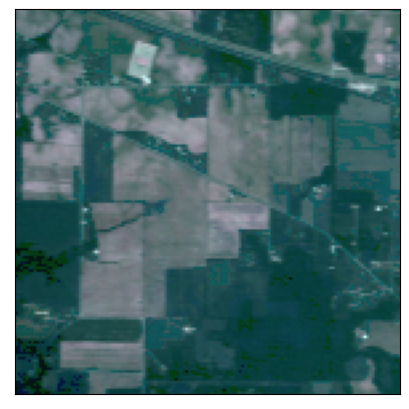

In [11]:
#visualizing rgb
mdata = np.moveaxis(pines, -1, 0)

ep.plot_rgb(mdata, (25, 10, 15), figsize =(10, 5)) 

plt.show()

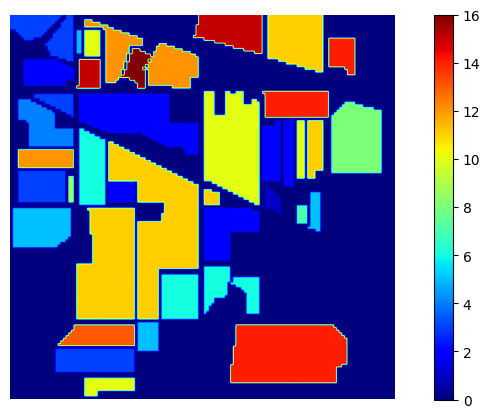

In [12]:
#visualizing of groundtruth
def plot_data(pines):
    fig = plt.figure(figsize = (10, 5))
    plt.imshow(pines, cmap = "jet")
    plt.colorbar()
    plt.axis("off")
    plt.show()

plot_data(groundtruth)

In [13]:
X = df[df["class"]!=0].iloc[:, :-1].values

y = tf.keras.utils.to_categorical(df[df["class"]!=0].iloc[:, -1].values, num_classes = np.unique(groundtruth).shape[0], dtype = "float32")

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, stratify = y)

In [15]:
print(f"Train Data: {X_train.shape}\nTest Data: {X_test.shape}")

Train Data: (7174, 200)
Test Data: (3075, 200)


In [16]:
model = Sequential(name = "Indian_Pines")

#Add input layer with the same shape as the training data
model.add(Input(shape = X_train[0].shape, name = "Input_Layer"))

#Add batch normalization layer to improve model stability and convergence
model.add(BatchNormalization(name = "BatchNormalization"))

#Add dense layers with 128 neurons and ReLU activation
model.add(Dense(units = 128, activation= "relu", name = "Layer1"))
model.add(Dense(units = 128, activation= "relu", name = "Layer2"))
model.add(Dense(units = 128, activation= "relu", name = "Layer3"))
model.add(Dense(units = 128, activation= "relu", name = "Layer4"))

#Add dropout layer to prevent overfitting
model.add(Dropout(rate = 0.2, name = "Dropout1",))

#Add dense layers with 64 neurons and ReLU activation
model.add(Dense(units = 64, activation= "relu", name = "Layer5"))
model.add(Dense(units = 64, activation= "relu", name = "Layer6"))
model.add(Dense(units = 64, activation= "relu", name = "Layer7"))
model.add(Dense(units = 64, activation= "relu", name = "Layer8"))

#Add another dropout layer
model.add(Dropout(rate = 0.2, name = "Dropout2"))

#Add dense layers with 32 neurons and ReLU activation
model.add(Dense(units = 32, activation= "relu", name = "Layer9"))
model.add(Dense(units = 32, activation= "relu", name = "Layer10"))
model.add(Dense(units = 32, activation= "relu", name = "Layer11"))
model.add(Dense(units = 32, activation= "relu", name = "Layer12"))

#Add output layer with softmax activation and the same number of units as the number of classes
model.add(Dense(units = y_train.shape[1], activation= "softmax", name = "Output_Layer"))

In [17]:
model.summary()

Model: "Indian_Pines"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BatchNormalization (BatchNo  (None, 200)              800       
 rmalization)                                                    
                                                                 
 Layer1 (Dense)              (None, 128)               25728     
                                                                 
 Layer2 (Dense)              (None, 128)               16512     
                                                                 
 Layer3 (Dense)              (None, 128)               16512     
                                                                 
 Layer4 (Dense)              (None, 128)               16512     
                                                                 
 Dropout1 (Dropout)          (None, 128)               0         
                                                      

In [18]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [19]:
es = EarlyStopping(monitor = "val_loss",
                   min_delta = 0,
                   patience = 15,
                   verbose = 1,
                   restore_best_weights = True)


In [20]:
checkpoint = ModelCheckpoint(filepath = "Indian_Pines_CNNModel.h5", 
                             monitor = "val_loss", 
                             mode = "min", 
                             save_best_only = True,
                             verbose = 1)

In [21]:
history = model.fit(x = X_train, y = y_train,
          validation_data = (X_test, y_test), 
          epochs = 150,
          callbacks = [es, checkpoint])

Epoch 1/150
214/225 [===========================>..] - ETA: 0s - loss: 1.8742 - accuracy: 0.3534
Epoch 1: val_loss improved from inf to 2.49073, saving model to Indian_Pines_CNNModel.h5
225/225 [==============================] - 4s 6ms/step - loss: 1.8603 - accuracy: 0.3548 - val_loss: 2.4907 - val_accuracy: 0.3694
Epoch 2/150
220/225 [============================>.] - ETA: 0s - loss: 1.4741 - accuracy: 0.4507
Epoch 2: val_loss improved from 2.49073 to 1.32835, saving model to Indian_Pines_CNNModel.h5
225/225 [==============================] - 1s 5ms/step - loss: 1.4720 - accuracy: 0.4519 - val_loss: 1.3283 - val_accuracy: 0.4995
Epoch 3/150
220/225 [============================>.] - ETA: 0s - loss: 1.3471 - accuracy: 0.4933
Epoch 3: val_loss improved from 1.32835 to 1.21692, saving model to Indian_Pines_CNNModel.h5
225/225 [==============================] - 1s 6ms/step - loss: 1.3487 - accuracy: 0.4932 - val_loss: 1.2169 - val_accuracy: 0.5239
Epoch 4/150
215/225 [====================

In [22]:
y_pred = model.predict(X_test)

97/97 [==============================] - 1s 3ms/step


In [23]:
score = model.evaluate(X_test, y_test, verbose = 0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.28436699509620667
Test accuracy: 0.9069918990135193


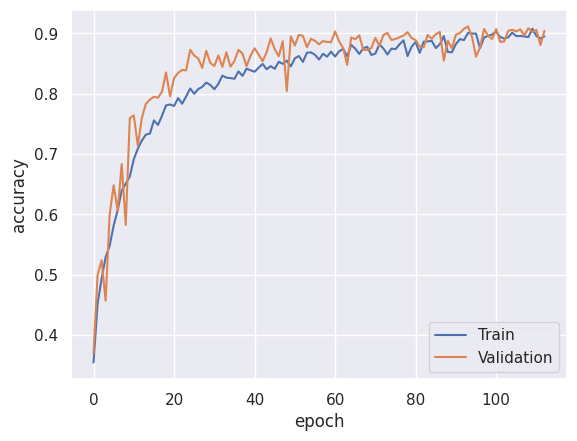

In [24]:
sns.set()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Train", "Validation"]) 
plt.show()

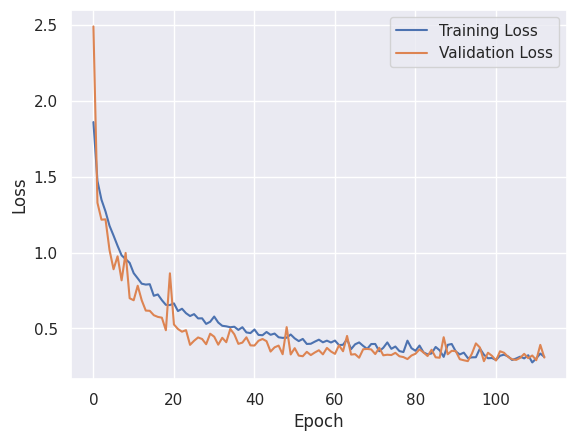

In [25]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [26]:
pred = np.argmax(model.predict(X_test), axis=1)

# Classification Report
print(classification_report(pred, np.argmax(y_test, 1),
      target_names = ["Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture", "Grass-trees", "Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill", "Soybean-mintill", "Soybean-clean", "Wheat", "Woods", "Buildings-Grass-Trees-Drives", "Stone-Steel-Towers"]))

97/97 [==============================] - 0s 2ms/step
                              precision    recall  f1-score   support

                     Alfalfa       0.86      0.80      0.83        15
                 Corn-notill       0.88      0.92      0.90       409
                Corn-mintill       0.79      0.90      0.84       217
                        Corn       0.85      0.69      0.76        87
               Grass-pasture       0.95      0.96      0.96       144
                 Grass-trees       0.99      0.95      0.97       228
         Grass-pasture-mowed       0.88      1.00      0.93         7
               Hay-windrowed       0.97      0.99      0.98       140
                        Oats       1.00      1.00      1.00         6
              Soybean-notill       0.95      0.87      0.90       319
             Soybean-mintill       0.91      0.90      0.91       744
               Soybean-clean       0.89      0.90      0.89       176
                       Wheat       0

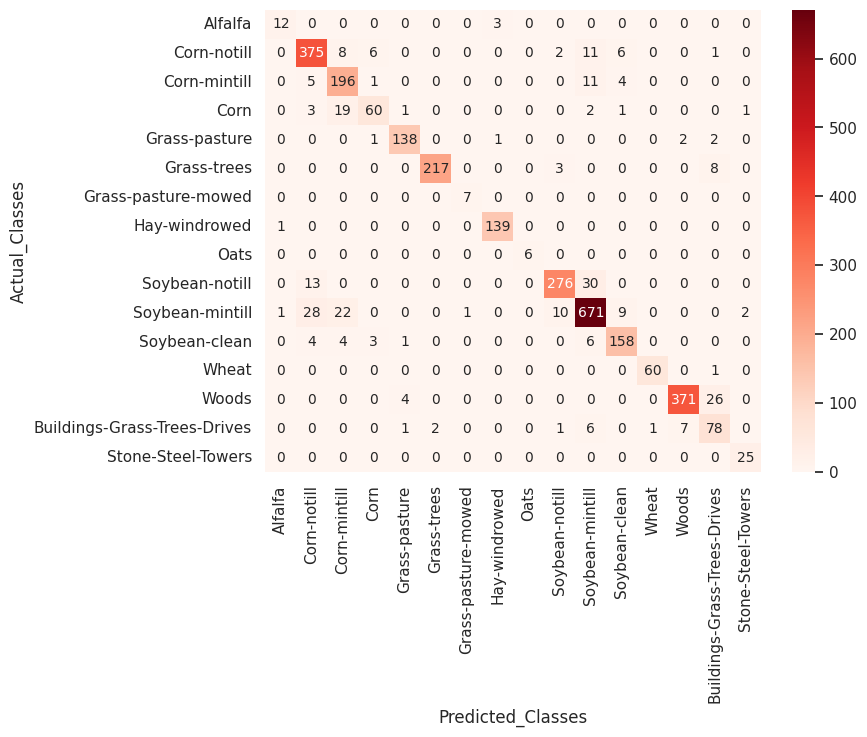

In [27]:
plt.figure(figsize = (8,6))

classes = ["Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture", "Grass-trees", "Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill", "Soybean-mintill", "Soybean-clean", "Wheat", "Woods", "Buildings-Grass-Trees-Drives", "Stone-Steel-Towers"]

mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

df_cm.index.name = "Actual_Classes"
df_cm.columns.name = "Predicted_Classes"

sns.heatmap(df_cm, annot = True, annot_kws = {"size": 10}, fmt= "d", cmap = "Reds")

plt.show()

In [28]:
import math
MSE = np.square(np.subtract(y_test,y_pred)).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n", RMSE)

Root Mean Square Error:
 0.08975927382727335


In [29]:
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error (MAE)", mean_absolute_error(y_test,y_pred))

Mean Absolute Error (MAE) 0.015928337


  0%|          | 0/21025 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 2/21025 [00:00<29:08, 12.02it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 4/21025 [00:00<25:32, 13.72it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 6/21025 [00:00<28:45, 12.18it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 8/21025 [00:00<30:38, 11.43it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 10/21025 [00:00<31:30, 11.11it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 12/21025 [00:01<30:50, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 14/21025 [00:01<29:16, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 16/21025 [00:01<29:13, 11.98it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 18/21025 [00:01<31:24, 11.15it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 20/21025 [00:01<30:39, 11.42it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 23/21025 [00:01<26:04, 13.43it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 72/21025 [00:02<03:32, 98.47it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 83/21025 [00:02<09:16, 37.64it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 91/21025 [00:03<12:13, 28.54it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 97/21025 [00:03<13:13, 26.37it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 102/21025 [00:04<15:40, 22.24it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 106/21025 [00:04<18:03, 19.30it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 109/21025 [00:04<19:28, 17.90it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 112/21025 [00:05<21:22, 16.31it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 114/21025 [00:05<21:39, 16.09it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 116/21025 [00:05<21:54, 15.91it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 118/21025 [00:05<23:03, 15.11it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 147/21025 [00:05<05:55, 58.76it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 155/21025 [00:06<10:24, 33.40it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 161/21025 [00:06<13:16, 26.18it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 166/21025 [00:06<13:18, 26.12it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 170/21025 [00:07<14:49, 23.45it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 218/21025 [00:07<04:18, 80.57it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 232/21025 [00:08<09:13, 37.53it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 242/21025 [00:08<11:01, 31.42it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 250/21025 [00:09<14:01, 24.70it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 256/21025 [00:09<15:42, 22.05it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 261/21025 [00:10<16:47, 20.61it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 265/21025 [00:10<15:56, 21.69it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 292/21025 [00:10<07:19, 47.21it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 301/21025 [00:11<11:33, 29.89it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 308/21025 [00:11<14:05, 24.51it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 313/21025 [00:11<14:17, 24.15it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 319/21025 [00:11<13:08, 26.27it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 324/21025 [00:12<12:49, 26.90it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 363/21025 [00:12<04:50, 71.12it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 373/21025 [00:13<09:03, 38.01it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 381/21025 [00:13<11:56, 28.80it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 387/21025 [00:13<12:41, 27.10it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 392/21025 [00:14<15:05, 22.79it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 396/21025 [00:14<16:35, 20.72it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 399/21025 [00:14<17:45, 19.37it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 402/21025 [00:14<18:22, 18.71it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 405/21025 [00:15<18:53, 18.20it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 408/21025 [00:15<20:23, 16.85it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 437/21025 [00:15<06:13, 55.14it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 445/21025 [00:16<10:29, 32.71it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 451/21025 [00:16<12:41, 27.03it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 456/21025 [00:16<12:48, 26.75it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 460/21025 [00:16<13:25, 25.53it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 465/21025 [00:16<12:18, 27.86it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 469/21025 [00:17<14:35, 23.47it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 508/21025 [00:17<04:30, 75.95it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 519/21025 [00:18<09:35, 35.63it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 528/21025 [00:18<13:07, 26.03it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 534/21025 [00:19<13:33, 25.18it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 539/21025 [00:19<15:04, 22.66it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 543/21025 [00:19<16:29, 20.69it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 547/21025 [00:20<18:35, 18.35it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 550/21025 [00:20<19:24, 17.58it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 553/21025 [00:20<21:03, 16.20it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 582/21025 [00:20<07:21, 46.35it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 588/21025 [00:21<10:46, 31.62it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 593/21025 [00:21<13:20, 25.52it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 597/21025 [00:21<13:51, 24.58it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 601/21025 [00:21<14:13, 23.94it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 604/21025 [00:22<16:52, 20.18it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 610/21025 [00:22<14:31, 23.42it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 613/21025 [00:22<16:25, 20.71it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 616/21025 [00:22<17:40, 19.24it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 651/21025 [00:23<05:10, 65.56it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 659/21025 [00:23<10:29, 32.33it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 665/21025 [00:24<13:28, 25.19it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 670/21025 [00:24<15:40, 21.64it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 674/21025 [00:24<18:14, 18.60it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 678/21025 [00:25<17:41, 19.17it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 681/21025 [00:25<20:09, 16.83it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 684/21025 [00:25<20:59, 16.15it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 686/21025 [00:25<22:22, 15.15it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 688/21025 [00:25<22:39, 14.96it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 690/21025 [00:26<23:42, 14.29it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 692/21025 [00:26<25:27, 13.31it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 694/21025 [00:26<25:46, 13.15it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 696/21025 [00:26<26:37, 12.73it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 698/21025 [00:26<26:36, 12.73it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 727/21025 [00:26<05:38, 60.04it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 734/21025 [00:27<10:42, 31.58it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 739/21025 [00:27<13:31, 25.00it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 744/21025 [00:28<13:05, 25.81it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 748/21025 [00:28<15:30, 21.79it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 751/21025 [00:28<14:48, 22.82it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 762/21025 [00:28<10:19, 32.69it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▎         | 766/21025 [00:28<11:15, 30.01it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 797/21025 [00:28<04:30, 74.85it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 807/21025 [00:29<09:18, 36.22it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 815/21025 [00:30<12:54, 26.10it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 821/21025 [00:30<14:32, 23.16it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 826/21025 [00:30<15:07, 22.26it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 830/21025 [00:31<16:20, 20.60it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 833/21025 [00:31<17:12, 19.55it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 836/21025 [00:31<17:54, 18.80it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 839/21025 [00:31<19:05, 17.63it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 841/21025 [00:31<19:55, 16.88it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 843/21025 [00:32<20:55, 16.07it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 874/21025 [00:32<05:30, 60.97it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 881/21025 [00:32<09:51, 34.08it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 886/21025 [00:33<10:43, 31.31it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 891/21025 [00:33<12:39, 26.52it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 895/21025 [00:33<14:16, 23.50it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 898/21025 [00:33<14:33, 23.05it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 901/21025 [00:34<16:22, 20.48it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 904/21025 [00:34<18:43, 17.91it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 908/21025 [00:34<17:02, 19.68it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 911/21025 [00:34<20:04, 16.70it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 941/21025 [00:34<05:45, 58.17it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 949/21025 [00:35<10:33, 31.71it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 955/21025 [00:35<13:28, 24.83it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 960/21025 [00:36<15:07, 22.12it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 964/21025 [00:36<16:37, 20.11it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 968/21025 [00:36<15:24, 21.70it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 972/21025 [00:36<16:51, 19.83it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 975/21025 [00:37<18:45, 17.81it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 978/21025 [00:37<19:23, 17.24it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 980/21025 [00:37<20:14, 16.51it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 982/21025 [00:37<20:18, 16.45it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 984/21025 [00:37<21:35, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 986/21025 [00:37<21:38, 15.43it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 988/21025 [00:38<21:38, 15.43it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 1020/21025 [00:38<04:29, 74.33it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 1028/21025 [00:38<09:21, 35.59it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 1034/21025 [00:39<09:58, 33.39it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 1039/21025 [00:39<12:04, 27.57it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 1043/21025 [00:39<11:45, 28.32it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 1047/21025 [00:39<14:30, 22.96it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 1050/21025 [00:39<15:20, 21.71it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 1053/21025 [00:40<16:03, 20.73it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1056/21025 [00:40<18:38, 17.85it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 1059/21025 [00:40<19:21, 17.19it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 1086/21025 [00:40<05:51, 56.72it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1094/21025 [00:41<10:27, 31.78it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 1100/21025 [00:41<14:16, 23.27it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1105/21025 [00:42<16:39, 19.94it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 1109/21025 [00:42<18:44, 17.71it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 1113/21025 [00:42<17:07, 19.37it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 1116/21025 [00:42<18:13, 18.20it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1119/21025 [00:43<20:30, 16.17it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1122/21025 [00:43<21:21, 15.53it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1124/21025 [00:43<22:17, 14.88it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 1126/21025 [00:43<22:03, 15.03it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 1128/21025 [00:43<22:11, 14.95it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1130/21025 [00:43<23:10, 14.30it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 1132/21025 [00:44<23:10, 14.30it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 1165/21025 [00:44<04:22, 75.57it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1174/21025 [00:44<08:33, 38.63it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1181/21025 [00:45<10:50, 30.49it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1187/21025 [00:45<13:31, 24.43it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1192/21025 [00:45<14:42, 22.49it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1196/21025 [00:46<13:58, 23.65it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1200/21025 [00:46<15:25, 21.42it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1203/21025 [00:46<18:10, 18.17it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 1206/21025 [00:46<19:32, 16.90it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1208/21025 [00:46<20:47, 15.89it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1231/21025 [00:47<07:17, 45.23it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 1237/21025 [00:47<10:37, 31.04it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1242/21025 [00:47<12:45, 25.83it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1246/21025 [00:48<14:33, 22.65it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1249/21025 [00:48<16:01, 20.58it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 1252/21025 [00:48<18:43, 17.60it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1255/21025 [00:48<19:51, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1259/21025 [00:48<17:24, 18.93it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1262/21025 [00:49<20:06, 16.38it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 1264/21025 [00:49<20:54, 15.76it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1266/21025 [00:49<21:45, 15.14it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1268/21025 [00:49<23:25, 14.06it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1270/21025 [00:49<24:33, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1272/21025 [00:50<24:16, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 1274/21025 [00:50<23:26, 14.05it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1276/21025 [00:50<24:51, 13.24it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 1278/21025 [00:50<24:48, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 1312/21025 [00:50<04:20, 75.61it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 1320/21025 [00:50<04:44, 69.28it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 1328/21025 [00:51<09:41, 33.90it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 1334/21025 [00:51<11:10, 29.38it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 1339/21025 [00:52<14:19, 22.90it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 1343/21025 [00:52<13:52, 23.65it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 1347/21025 [00:52<15:34, 21.05it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 1350/21025 [00:52<16:49, 19.49it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 1353/21025 [00:52<17:53, 18.32it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 1356/21025 [00:53<17:12, 19.05it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1380/21025 [00:53<06:11, 52.93it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1387/21025 [00:53<09:39, 33.88it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1392/21025 [00:53<12:10, 26.88it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1396/21025 [00:54<14:03, 23.26it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1400/21025 [00:54<16:34, 19.74it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1404/21025 [00:54<16:07, 20.29it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1407/21025 [00:55<18:41, 17.49it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1410/21025 [00:55<21:25, 15.26it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1412/21025 [00:55<22:09, 14.75it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1414/21025 [00:55<23:22, 13.98it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1416/21025 [00:55<24:39, 13.25it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 1418/21025 [00:56<26:56, 12.13it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1420/21025 [00:56<26:12, 12.47it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1422/21025 [00:56<26:28, 12.34it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 1426/21025 [00:56<22:27, 14.55it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1428/21025 [00:56<24:34, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1430/21025 [00:56<24:22, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1432/21025 [00:57<23:44, 13.75it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1434/21025 [00:57<23:55, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1465/21025 [00:57<04:43, 69.08it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 1473/21025 [00:57<09:33, 34.11it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1479/21025 [00:58<10:55, 29.80it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1484/21025 [00:58<13:03, 24.94it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1488/21025 [00:58<13:03, 24.92it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1492/21025 [00:59<16:20, 19.92it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1495/21025 [00:59<17:21, 18.76it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1498/21025 [00:59<18:50, 17.28it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1500/21025 [00:59<19:30, 16.69it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1529/21025 [00:59<05:55, 54.89it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1536/21025 [01:00<09:49, 33.04it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1541/21025 [01:00<12:53, 25.20it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1545/21025 [01:01<15:06, 21.49it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1549/21025 [01:01<14:20, 22.64it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1552/21025 [01:01<15:30, 20.92it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1555/21025 [01:01<17:24, 18.63it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1558/21025 [01:01<20:01, 16.21it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1560/21025 [01:02<21:28, 15.11it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 1562/21025 [01:02<23:22, 13.88it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1564/21025 [01:02<23:49, 13.61it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1566/21025 [01:02<23:49, 13.61it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1568/21025 [01:02<24:01, 13.49it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 1572/21025 [01:02<19:15, 16.84it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1574/21025 [01:03<20:23, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 1576/21025 [01:03<20:37, 15.72it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1578/21025 [01:03<20:34, 15.75it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 1580/21025 [01:03<22:20, 14.50it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1610/21025 [01:03<04:47, 67.42it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1617/21025 [01:04<08:29, 38.07it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1622/21025 [01:04<10:12, 31.70it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1627/21025 [01:04<12:13, 26.44it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1631/21025 [01:04<11:53, 27.18it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1635/21025 [01:05<14:33, 22.20it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1638/21025 [01:05<16:09, 19.99it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1641/21025 [01:05<17:42, 18.24it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 1644/21025 [01:05<19:24, 16.64it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1652/21025 [01:05<13:03, 24.71it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1655/21025 [01:06<13:12, 24.44it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1678/21025 [01:06<05:39, 56.94it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1685/21025 [01:06<09:13, 34.92it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1690/21025 [01:07<11:43, 27.48it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1694/21025 [01:07<11:45, 27.42it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1698/21025 [01:07<13:49, 23.29it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1701/21025 [01:07<15:51, 20.32it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1704/21025 [01:07<18:07, 17.77it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1707/21025 [01:08<20:01, 16.08it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1709/21025 [01:08<20:29, 15.72it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1711/21025 [01:08<20:57, 15.36it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1713/21025 [01:08<20:58, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1717/21025 [01:08<17:42, 18.17it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1719/21025 [01:08<19:28, 16.52it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1721/21025 [01:09<20:24, 15.77it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1723/21025 [01:09<21:31, 14.94it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1725/21025 [01:09<22:33, 14.26it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1756/21025 [01:09<04:31, 71.02it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 1764/21025 [01:10<08:32, 37.56it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1770/21025 [01:10<09:59, 32.10it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1775/21025 [01:10<11:28, 27.96it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1779/21025 [01:10<12:52, 24.92it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1783/21025 [01:11<14:45, 21.74it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 1786/21025 [01:11<14:51, 21.58it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 1797/21025 [01:11<09:36, 33.36it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 1802/21025 [01:11<12:39, 25.31it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 1826/21025 [01:11<06:07, 52.28it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 1833/21025 [01:12<09:32, 33.53it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 1839/21025 [01:12<10:29, 30.50it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1844/21025 [01:13<12:45, 25.05it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1848/21025 [01:13<15:00, 21.29it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1851/21025 [01:13<16:20, 19.55it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1854/21025 [01:13<17:47, 17.95it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1857/21025 [01:14<19:30, 16.37it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1861/21025 [01:14<16:52, 18.93it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1864/21025 [01:14<18:29, 17.27it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1866/21025 [01:14<19:13, 16.60it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1868/21025 [01:14<20:32, 15.55it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1870/21025 [01:14<20:42, 15.42it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1901/21025 [01:14<04:35, 69.42it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1909/21025 [01:15<09:09, 34.82it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1915/21025 [01:15<10:33, 30.18it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1920/21025 [01:16<12:01, 26.48it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1924/21025 [01:16<12:43, 25.02it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1928/21025 [01:16<14:33, 21.86it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1931/21025 [01:16<14:23, 22.10it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 1934/21025 [01:16<15:29, 20.54it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1942/21025 [01:17<11:13, 28.35it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1946/21025 [01:17<14:27, 21.99it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1949/21025 [01:17<16:59, 18.71it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1974/21025 [01:17<06:18, 50.34it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1981/21025 [01:18<09:16, 34.21it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1987/21025 [01:18<11:27, 27.68it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1992/21025 [01:18<13:19, 23.79it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1996/21025 [01:19<15:12, 20.86it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 1999/21025 [01:19<16:00, 19.82it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2002/21025 [01:19<16:45, 18.92it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 2006/21025 [01:19<15:12, 20.85it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 2009/21025 [01:19<16:31, 19.17it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 2012/21025 [01:20<17:53, 17.70it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 2014/21025 [01:20<18:44, 16.91it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2046/21025 [01:20<04:36, 68.64it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 2055/21025 [01:21<08:19, 38.00it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 2062/21025 [01:21<10:49, 29.17it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 2067/21025 [01:21<11:32, 27.37it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2072/21025 [01:22<13:22, 23.60it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2076/21025 [01:22<13:44, 22.99it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 2079/21025 [01:22<14:44, 21.43it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2082/21025 [01:22<14:32, 21.71it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2086/21025 [01:22<13:48, 22.87it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 2089/21025 [01:22<15:41, 20.10it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 2092/21025 [01:23<16:46, 18.80it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 2095/21025 [01:23<17:37, 17.90it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 2097/21025 [01:23<19:15, 16.39it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 2123/21025 [01:23<05:51, 53.83it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 2129/21025 [01:23<08:23, 37.50it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 2134/21025 [01:24<11:18, 27.85it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 2138/21025 [01:24<12:56, 24.33it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 2141/21025 [01:24<14:26, 21.80it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 2144/21025 [01:25<16:07, 19.52it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 2147/21025 [01:25<17:59, 17.49it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 2151/21025 [01:25<15:55, 19.75it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 2154/21025 [01:25<18:18, 17.18it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 2156/21025 [01:25<19:59, 15.73it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 2158/21025 [01:25<21:46, 14.44it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 2160/21025 [01:26<22:16, 14.12it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 2191/21025 [01:26<04:30, 69.50it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 2202/21025 [01:26<08:10, 38.41it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2210/21025 [01:27<10:10, 30.82it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 2216/21025 [01:27<12:24, 25.26it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2221/21025 [01:27<13:36, 23.04it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 2225/21025 [01:28<15:55, 19.68it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 2228/21025 [01:29<29:09, 10.74it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 2231/21025 [01:29<27:12, 11.51it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 2234/21025 [01:29<28:08, 11.13it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 2236/21025 [01:29<27:59, 11.19it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 2238/21025 [01:30<28:00, 11.18it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2240/21025 [01:30<28:33, 10.96it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2242/21025 [01:30<27:17, 11.47it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 2244/21025 [01:30<26:43, 11.71it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 2246/21025 [01:30<24:04, 13.00it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 2273/21025 [01:30<04:58, 62.84it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2282/21025 [01:31<11:40, 26.74it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 2289/21025 [01:32<15:40, 19.91it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 2294/21025 [01:32<17:38, 17.69it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2298/21025 [01:32<17:55, 17.41it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2302/21025 [01:33<19:44, 15.81it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2305/21025 [01:33<21:00, 14.85it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 2340/21025 [01:33<06:19, 49.18it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 2348/21025 [01:34<08:01, 38.78it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 2357/21025 [01:34<06:58, 44.65it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 2364/21025 [01:34<11:41, 26.62it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 2370/21025 [01:35<13:36, 22.85it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 2374/21025 [01:35<15:09, 20.50it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 2378/21025 [01:35<16:58, 18.31it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 2381/21025 [01:36<17:58, 17.28it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 2384/21025 [01:36<18:42, 16.60it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 2386/21025 [01:36<19:11, 16.18it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 2388/21025 [01:36<20:58, 14.81it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 2390/21025 [01:36<21:20, 14.55it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2418/21025 [01:36<05:25, 57.23it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2425/21025 [01:37<09:22, 33.09it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 2431/21025 [01:37<12:58, 23.88it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2436/21025 [01:38<14:50, 20.88it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2440/21025 [01:38<14:18, 21.64it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2444/21025 [01:38<16:30, 18.76it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 2447/21025 [01:38<18:14, 16.98it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2450/21025 [01:39<19:36, 15.79it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2471/21025 [01:39<07:21, 42.01it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2479/21025 [01:39<11:40, 26.47it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2485/21025 [01:40<13:08, 23.53it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2490/21025 [01:40<13:42, 22.53it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2494/21025 [01:40<14:54, 20.72it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2498/21025 [01:41<16:08, 19.14it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2502/21025 [01:41<15:15, 20.22it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2505/21025 [01:41<16:56, 18.23it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2508/21025 [01:41<18:09, 17.00it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2511/21025 [01:41<18:00, 17.13it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2513/21025 [01:42<19:00, 16.22it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2515/21025 [01:42<20:04, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2517/21025 [01:42<20:05, 15.35it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2520/21025 [01:42<17:52, 17.25it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2522/21025 [01:42<19:09, 16.09it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 2524/21025 [01:42<21:12, 14.54it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2526/21025 [01:42<21:25, 14.39it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2528/21025 [01:43<21:58, 14.02it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 2530/21025 [01:43<23:27, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2532/21025 [01:43<23:36, 13.06it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2534/21025 [01:43<24:53, 12.38it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2536/21025 [01:43<23:38, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 2568/21025 [01:43<04:08, 74.22it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2577/21025 [01:44<08:43, 35.22it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 2584/21025 [01:44<11:36, 26.46it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2589/21025 [01:45<13:05, 23.46it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2593/21025 [01:45<15:00, 20.46it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2597/21025 [01:45<14:05, 21.78it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 2617/21025 [01:45<06:55, 44.30it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2624/21025 [01:46<10:28, 29.27it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2630/21025 [01:46<13:29, 22.71it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2638/21025 [01:47<11:18, 27.10it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2643/21025 [01:47<13:10, 23.26it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2647/21025 [01:47<12:49, 23.87it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2651/21025 [01:47<14:41, 20.84it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2654/21025 [01:47<14:51, 20.61it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 2657/21025 [01:48<17:38, 17.36it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2660/21025 [01:48<19:36, 15.61it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 2662/21025 [01:48<21:03, 14.54it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2664/21025 [01:48<22:52, 13.38it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 2666/21025 [01:49<24:53, 12.30it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2668/21025 [01:49<25:07, 12.18it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2670/21025 [01:49<25:35, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2672/21025 [01:49<25:29, 12.00it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2674/21025 [01:49<25:36, 11.94it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2676/21025 [01:49<26:07, 11.71it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2678/21025 [01:50<24:43, 12.37it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2680/21025 [01:50<23:29, 13.01it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2715/21025 [01:50<03:58, 76.75it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2723/21025 [01:50<08:22, 36.42it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2729/21025 [01:51<10:42, 28.49it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2734/21025 [01:51<12:25, 24.55it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2738/21025 [01:52<14:43, 20.70it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2741/21025 [01:52<14:48, 20.58it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2762/21025 [01:52<07:05, 42.94it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2768/21025 [01:52<10:46, 28.24it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 2773/21025 [01:53<12:19, 24.69it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2777/21025 [01:53<13:44, 22.14it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2783/21025 [01:53<11:39, 26.08it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2787/21025 [01:53<13:24, 22.66it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2790/21025 [01:53<13:55, 21.83it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2793/21025 [01:54<14:13, 21.37it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2796/21025 [01:54<16:09, 18.80it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2799/21025 [01:54<16:40, 18.22it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2801/21025 [01:54<18:27, 16.46it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2803/21025 [01:54<20:04, 15.13it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2805/21025 [01:54<20:11, 15.04it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2808/21025 [01:55<18:58, 16.00it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2810/21025 [01:55<21:12, 14.32it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2812/21025 [01:55<22:24, 13.54it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2814/21025 [01:55<23:15, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2816/21025 [01:55<22:27, 13.51it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 2818/21025 [01:55<22:13, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2820/21025 [01:56<21:38, 14.02it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2822/21025 [01:56<21:58, 13.80it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 2824/21025 [01:56<21:10, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 2826/21025 [01:56<20:34, 14.75it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 2865/21025 [01:56<03:20, 90.75it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 2874/21025 [01:57<07:02, 43.01it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 2881/21025 [01:57<10:06, 29.92it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 2886/21025 [01:58<11:25, 26.47it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2907/21025 [01:58<06:53, 43.77it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 2914/21025 [01:58<10:28, 28.81it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2919/21025 [01:59<12:23, 24.34it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2923/21025 [01:59<13:34, 22.24it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2927/21025 [01:59<12:57, 23.26it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2931/21025 [01:59<14:17, 21.10it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2934/21025 [02:00<15:26, 19.52it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2938/21025 [02:00<13:57, 21.59it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2941/21025 [02:00<16:21, 18.43it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 2944/21025 [02:00<15:55, 18.93it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2947/21025 [02:00<17:26, 17.27it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2949/21025 [02:00<19:07, 15.76it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2952/21025 [02:01<17:44, 16.98it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2954/21025 [02:01<19:50, 15.17it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2956/21025 [02:01<19:59, 15.06it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2958/21025 [02:01<21:41, 13.88it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2960/21025 [02:01<22:27, 13.41it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2962/21025 [02:01<21:54, 13.74it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 2964/21025 [02:02<21:49, 13.79it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2966/21025 [02:02<22:34, 13.33it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 2968/21025 [02:02<22:31, 13.36it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 2970/21025 [02:02<23:57, 12.56it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 3012/21025 [02:02<03:33, 84.51it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 3021/21025 [02:03<05:58, 50.23it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 3028/21025 [02:03<06:02, 49.62it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 3034/21025 [02:03<06:18, 47.58it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 3052/21025 [02:03<04:34, 65.39it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 3060/21025 [02:04<09:03, 33.04it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 3066/21025 [02:04<11:58, 25.00it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 3071/21025 [02:04<12:38, 23.68it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 3075/21025 [02:05<13:52, 21.56it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 3078/21025 [02:05<15:34, 19.21it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 3082/21025 [02:05<14:56, 20.02it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 3085/21025 [02:05<16:14, 18.41it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 3088/21025 [02:06<16:07, 18.54it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 3091/21025 [02:06<18:19, 16.31it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 3093/21025 [02:06<19:30, 15.32it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 3095/21025 [02:06<20:16, 14.74it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 3098/21025 [02:06<17:54, 16.69it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 3100/21025 [02:06<18:43, 15.96it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 3102/21025 [02:07<20:11, 14.80it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 3104/21025 [02:07<20:39, 14.45it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 3106/21025 [02:07<21:52, 13.65it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 3108/21025 [02:07<22:52, 13.05it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 3110/21025 [02:07<24:21, 12.26it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 3112/21025 [02:07<24:42, 12.08it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 3114/21025 [02:08<23:53, 12.49it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 3116/21025 [02:08<23:29, 12.71it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 3162/21025 [02:08<03:02, 97.69it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 3173/21025 [02:08<03:23, 87.61it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 3183/21025 [02:08<03:38, 81.70it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 3197/21025 [02:08<03:30, 84.75it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 3206/21025 [02:09<07:23, 40.17it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 3213/21025 [02:09<09:52, 30.04it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 3219/21025 [02:10<10:42, 27.73it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 3224/21025 [02:10<13:14, 22.40it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 3228/21025 [02:10<12:35, 23.56it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 3232/21025 [02:11<14:39, 20.22it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 3235/21025 [02:11<14:34, 20.35it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 3238/21025 [02:11<15:58, 18.56it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 3241/21025 [02:11<18:18, 16.19it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 3244/21025 [02:11<17:22, 17.05it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 3246/21025 [02:11<18:04, 16.40it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 3248/21025 [02:12<18:09, 16.31it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 3250/21025 [02:12<19:52, 14.91it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 3252/21025 [02:12<20:11, 14.67it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 3254/21025 [02:12<19:58, 14.82it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 3256/21025 [02:12<19:43, 15.01it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 3258/21025 [02:12<19:22, 15.29it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3260/21025 [02:12<21:44, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3318/21025 [02:13<02:18, 127.64it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 3333/21025 [02:13<02:24, 122.57it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3347/21025 [02:13<04:35, 64.19it/s] 

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3357/21025 [02:14<07:54, 37.24it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3365/21025 [02:14<09:03, 32.49it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 3371/21025 [02:15<09:34, 30.72it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 3376/21025 [02:15<11:11, 26.28it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 3380/21025 [02:15<12:26, 23.64it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3384/21025 [02:15<14:40, 20.04it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 3387/21025 [02:16<14:36, 20.12it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3390/21025 [02:16<16:00, 18.37it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3393/21025 [02:16<17:30, 16.78it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3395/21025 [02:16<18:33, 15.83it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 3397/21025 [02:16<19:34, 15.01it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 3399/21025 [02:17<20:18, 14.47it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3401/21025 [02:17<20:22, 14.42it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 3403/21025 [02:17<20:12, 14.54it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 3405/21025 [02:17<20:03, 14.64it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3486/21025 [02:17<01:43, 170.09it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3504/21025 [02:18<06:25, 45.43it/s] 

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3517/21025 [02:19<08:17, 35.16it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 3527/21025 [02:20<09:39, 30.18it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 3535/21025 [02:20<10:51, 26.86it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 3541/21025 [02:21<12:17, 23.70it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 3546/21025 [02:21<13:32, 21.52it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 3550/21025 [02:21<13:14, 22.01it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 3632/21025 [02:21<02:50, 101.72it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 3653/21025 [02:22<05:48, 49.83it/s] 

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 3669/21025 [02:23<07:35, 38.07it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 3681/21025 [02:24<08:49, 32.78it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 3690/21025 [02:25<10:54, 26.48it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3697/21025 [02:25<10:44, 26.88it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 3777/21025 [02:25<03:37, 79.40it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3793/21025 [02:26<06:21, 45.11it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 3805/21025 [02:27<07:33, 37.99it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3820/21025 [02:27<06:35, 43.54it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 3829/21025 [02:27<08:31, 33.61it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3836/21025 [02:28<10:56, 26.20it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3841/21025 [02:28<10:45, 26.64it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 3942/21025 [02:28<02:37, 108.58it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 3963/21025 [02:29<03:28, 81.93it/s] 

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3979/21025 [02:29<04:10, 68.11it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3992/21025 [02:30<04:37, 61.34it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 4280/21025 [02:30<00:52, 316.83it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 4333/21025 [02:32<03:02, 91.49it/s] 

1/1 [==============================] - 0s 25ms/step


 21%|██        | 4371/21025 [02:33<03:26, 80.84it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 4399/21025 [02:35<05:48, 47.76it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 4419/21025 [02:36<06:31, 42.39it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 4434/21025 [02:36<06:49, 40.52it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 4446/21025 [02:37<07:00, 39.42it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 4455/21025 [02:37<08:23, 32.91it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 4462/21025 [02:38<09:32, 28.95it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 4468/21025 [02:38<10:30, 26.25it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 4473/21025 [02:38<10:06, 27.30it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 4506/21025 [02:39<05:25, 50.78it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 4515/21025 [02:39<07:57, 34.59it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4522/21025 [02:40<08:49, 31.17it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4527/21025 [02:40<10:46, 25.53it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4531/21025 [02:40<11:38, 23.61it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 4535/21025 [02:41<12:48, 21.46it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4538/21025 [02:41<13:49, 19.87it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4541/21025 [02:41<15:14, 18.03it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4543/21025 [02:41<16:31, 16.62it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4545/21025 [02:41<17:16, 15.90it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4547/21025 [02:41<17:26, 15.75it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4549/21025 [02:42<18:01, 15.23it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4551/21025 [02:42<18:23, 14.93it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4553/21025 [02:42<19:53, 13.80it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4555/21025 [02:42<20:29, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4570/21025 [02:42<07:20, 37.38it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 4574/21025 [02:42<07:58, 34.39it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4578/21025 [02:43<08:51, 30.93it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4582/21025 [02:43<11:43, 23.36it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4592/21025 [02:43<08:04, 33.92it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4596/21025 [02:43<10:42, 25.55it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4600/21025 [02:44<12:16, 22.31it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 4603/21025 [02:44<13:31, 20.23it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4606/21025 [02:44<15:43, 17.41it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 4608/21025 [02:44<16:05, 17.00it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 4610/21025 [02:44<17:33, 15.59it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4612/21025 [02:44<18:02, 15.17it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4614/21025 [02:45<18:44, 14.59it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4644/21025 [02:45<04:13, 64.49it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4651/21025 [02:45<05:40, 48.14it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 4657/21025 [02:45<08:37, 31.62it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4662/21025 [02:46<11:00, 24.78it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4666/21025 [02:46<10:34, 25.78it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4670/21025 [02:46<12:14, 22.28it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4673/21025 [02:46<14:03, 19.40it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4676/21025 [02:47<14:51, 18.34it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4679/21025 [02:47<15:29, 17.59it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 4681/21025 [02:47<15:48, 17.23it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4683/21025 [02:47<16:55, 16.09it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 4685/21025 [02:47<17:03, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4687/21025 [02:47<17:21, 15.69it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4689/21025 [02:48<17:26, 15.62it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4691/21025 [02:48<18:04, 15.06it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4693/21025 [02:48<18:58, 14.34it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4695/21025 [02:48<19:18, 14.09it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4697/21025 [02:48<20:17, 13.42it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 4699/21025 [02:48<21:05, 12.90it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 4701/21025 [02:48<19:08, 14.21it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4715/21025 [02:49<07:17, 37.30it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 4719/21025 [02:49<07:41, 35.31it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 4723/21025 [02:49<08:14, 32.95it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 4727/21025 [02:49<11:15, 24.11it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4732/21025 [02:49<10:14, 26.52it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4737/21025 [02:49<10:03, 26.97it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4740/21025 [02:50<12:14, 22.17it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4743/21025 [02:50<15:14, 17.80it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4745/21025 [02:50<16:53, 16.06it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4747/21025 [02:50<18:10, 14.93it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 4749/21025 [02:51<19:45, 13.73it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4751/21025 [02:51<20:25, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4753/21025 [02:51<20:10, 13.45it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4755/21025 [02:51<20:08, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4757/21025 [02:51<19:29, 13.91it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4759/21025 [02:51<19:35, 13.84it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 4789/21025 [02:51<03:50, 70.55it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4797/21025 [02:52<06:47, 39.85it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4803/21025 [02:52<09:28, 28.53it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4808/21025 [02:53<12:03, 22.42it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4812/21025 [02:53<11:29, 23.52it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4816/21025 [02:53<12:50, 21.04it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4819/21025 [02:53<13:59, 19.29it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4822/21025 [02:54<14:51, 18.18it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4825/21025 [02:54<16:05, 16.77it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4827/21025 [02:54<17:24, 15.50it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4829/21025 [02:54<19:00, 14.21it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4831/21025 [02:54<20:10, 13.38it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 4833/21025 [02:54<19:59, 13.50it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4835/21025 [02:55<19:34, 13.79it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4837/21025 [02:55<19:47, 13.63it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4839/21025 [02:55<20:20, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4841/21025 [02:55<19:52, 13.57it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4843/21025 [02:55<19:15, 14.01it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4845/21025 [02:55<21:03, 12.80it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4860/21025 [02:56<07:29, 35.94it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4864/21025 [02:56<07:49, 34.45it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4868/21025 [02:56<08:02, 33.49it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4872/21025 [02:56<11:00, 24.45it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4877/21025 [02:56<10:06, 26.62it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4880/21025 [02:56<10:26, 25.76it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4883/21025 [02:57<10:49, 24.86it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4886/21025 [02:57<13:18, 20.22it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 4889/21025 [02:57<15:10, 17.73it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4891/21025 [02:57<17:13, 15.62it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4893/21025 [02:57<17:54, 15.02it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4895/21025 [02:57<18:13, 14.76it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4897/21025 [02:58<18:07, 14.83it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4899/21025 [02:58<18:02, 14.90it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4901/21025 [02:58<19:14, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4903/21025 [02:58<19:53, 13.50it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 4905/21025 [02:58<19:10, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 4913/21025 [02:58<09:55, 27.07it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4916/21025 [02:58<11:29, 23.37it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4935/21025 [02:59<05:12, 51.56it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 4941/21025 [02:59<08:52, 30.21it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 4946/21025 [02:59<08:26, 31.76it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 4950/21025 [03:00<11:44, 22.82it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4954/21025 [03:00<13:43, 19.51it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 4958/21025 [03:00<12:53, 20.78it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 4961/21025 [03:00<15:12, 17.60it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 4964/21025 [03:01<16:54, 15.83it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 4966/21025 [03:01<17:00, 15.73it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 4968/21025 [03:01<18:42, 14.31it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 4970/21025 [03:01<19:43, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 4972/21025 [03:01<19:51, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 4974/21025 [03:01<19:15, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 4976/21025 [03:02<18:59, 14.09it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 4978/21025 [03:02<18:51, 14.19it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 4980/21025 [03:02<18:17, 14.62it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 4982/21025 [03:02<18:21, 14.57it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 4984/21025 [03:02<18:38, 14.34it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 4986/21025 [03:02<18:36, 14.36it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 4988/21025 [03:02<19:15, 13.88it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4990/21025 [03:03<20:02, 13.33it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 5005/21025 [03:03<06:49, 39.17it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5009/21025 [03:03<07:40, 34.82it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 5013/21025 [03:03<08:23, 31.79it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 5017/21025 [03:03<11:22, 23.47it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5020/21025 [03:04<13:24, 19.90it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5023/21025 [03:04<16:01, 16.63it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5027/21025 [03:04<13:44, 19.41it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5030/21025 [03:04<14:32, 18.34it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 5033/21025 [03:04<16:10, 16.47it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 5035/21025 [03:04<16:30, 16.15it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 5037/21025 [03:05<17:51, 14.93it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 5039/21025 [03:05<17:43, 15.03it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5041/21025 [03:05<19:18, 13.80it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 5043/21025 [03:05<18:56, 14.06it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 5045/21025 [03:05<18:55, 14.08it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5047/21025 [03:05<20:00, 13.30it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5049/21025 [03:06<20:25, 13.04it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 5056/21025 [03:06<12:28, 21.34it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 5059/21025 [03:06<14:02, 18.96it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 5061/21025 [03:06<15:03, 17.68it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 5063/21025 [03:06<16:50, 15.79it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 5080/21025 [03:06<06:06, 43.50it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5085/21025 [03:07<09:28, 28.04it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5089/21025 [03:07<11:42, 22.70it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5094/21025 [03:07<10:47, 24.60it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5098/21025 [03:08<13:00, 20.39it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5102/21025 [03:08<12:44, 20.84it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 5105/21025 [03:08<14:42, 18.04it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5108/21025 [03:08<16:11, 16.38it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5110/21025 [03:08<17:13, 15.40it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5112/21025 [03:09<18:10, 14.59it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 5114/21025 [03:09<18:22, 14.43it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5116/21025 [03:09<18:25, 14.39it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5118/21025 [03:09<18:57, 13.98it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 5120/21025 [03:09<20:30, 12.92it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5122/21025 [03:09<20:37, 12.85it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5124/21025 [03:09<20:41, 12.81it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5126/21025 [03:10<20:16, 13.07it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5128/21025 [03:10<20:53, 12.68it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 5130/21025 [03:10<20:28, 12.94it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 5132/21025 [03:10<19:26, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 5134/21025 [03:10<19:08, 13.84it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5149/21025 [03:10<06:26, 41.13it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5154/21025 [03:11<08:20, 31.71it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5158/21025 [03:11<08:41, 30.41it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5162/21025 [03:11<11:15, 23.49it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5165/21025 [03:11<12:50, 20.60it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 5168/21025 [03:11<14:25, 18.32it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 5172/21025 [03:12<12:40, 20.84it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5175/21025 [03:12<14:04, 18.77it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5178/21025 [03:12<15:31, 17.00it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5180/21025 [03:12<16:00, 16.49it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5182/21025 [03:12<16:09, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 5184/21025 [03:12<16:47, 15.72it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5186/21025 [03:13<16:46, 15.74it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5188/21025 [03:13<16:58, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 5190/21025 [03:13<16:49, 15.68it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5192/21025 [03:13<18:15, 14.45it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 5194/21025 [03:13<18:46, 14.06it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 5200/21025 [03:13<11:34, 22.79it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 5203/21025 [03:14<13:29, 19.54it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5206/21025 [03:14<14:38, 18.00it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5208/21025 [03:14<16:04, 16.40it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 5210/21025 [03:14<16:30, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 5212/21025 [03:14<16:34, 15.91it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5225/21025 [03:14<06:51, 38.42it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5230/21025 [03:15<09:57, 26.45it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 5234/21025 [03:15<11:40, 22.56it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5237/21025 [03:15<11:35, 22.71it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 5241/21025 [03:15<10:42, 24.57it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5244/21025 [03:15<12:51, 20.44it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5248/21025 [03:16<12:23, 21.22it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5251/21025 [03:16<14:00, 18.76it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 5254/21025 [03:16<15:15, 17.22it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 5256/21025 [03:16<15:35, 16.85it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 5258/21025 [03:16<16:55, 15.52it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5260/21025 [03:16<16:59, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 5262/21025 [03:17<17:20, 15.15it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5264/21025 [03:17<17:56, 14.64it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 5266/21025 [03:17<18:41, 14.05it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5268/21025 [03:17<18:47, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5270/21025 [03:17<18:34, 14.13it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 5272/21025 [03:17<18:53, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 5274/21025 [03:17<18:34, 14.14it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 5276/21025 [03:18<18:56, 13.86it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 5278/21025 [03:18<19:04, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5280/21025 [03:18<18:18, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5295/21025 [03:18<06:01, 43.48it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 5300/21025 [03:18<06:46, 38.64it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5305/21025 [03:18<08:57, 29.27it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 5309/21025 [03:19<12:12, 21.46it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5312/21025 [03:19<13:11, 19.85it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 5315/21025 [03:19<14:13, 18.41it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 5318/21025 [03:19<13:39, 19.17it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 5321/21025 [03:19<14:48, 17.67it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 5323/21025 [03:20<15:44, 16.62it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 5325/21025 [03:20<17:18, 15.12it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5327/21025 [03:20<17:08, 15.26it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 5329/21025 [03:20<17:42, 14.77it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 5331/21025 [03:20<18:20, 14.26it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5333/21025 [03:20<18:43, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5335/21025 [03:21<18:23, 14.22it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5337/21025 [03:21<17:53, 14.61it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5339/21025 [03:21<18:00, 14.51it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 5344/21025 [03:21<13:04, 19.98it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5346/21025 [03:21<15:01, 17.39it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 5348/21025 [03:21<15:58, 16.35it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 5350/21025 [03:21<16:56, 15.42it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 5352/21025 [03:22<18:42, 13.97it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 5354/21025 [03:22<20:02, 13.03it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 5356/21025 [03:22<20:12, 12.92it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 5358/21025 [03:22<19:27, 13.42it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 5360/21025 [03:22<19:55, 13.10it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 5370/21025 [03:22<09:07, 28.60it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5373/21025 [03:23<11:27, 22.77it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 5376/21025 [03:23<13:25, 19.43it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5379/21025 [03:23<14:52, 17.53it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 5381/21025 [03:23<15:21, 16.97it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5387/21025 [03:23<11:23, 22.87it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 5390/21025 [03:23<11:44, 22.19it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5393/21025 [03:24<11:36, 22.46it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 5396/21025 [03:24<13:03, 19.96it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5399/21025 [03:24<14:01, 18.57it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 5401/21025 [03:24<15:06, 17.23it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5403/21025 [03:24<15:42, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5405/21025 [03:24<16:36, 15.67it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5407/21025 [03:25<17:33, 14.82it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 5409/21025 [03:25<17:57, 14.49it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 5411/21025 [03:25<17:52, 14.56it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 5413/21025 [03:25<17:49, 14.60it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 5415/21025 [03:25<18:40, 13.93it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5417/21025 [03:25<19:44, 13.18it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5419/21025 [03:26<20:32, 12.66it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5421/21025 [03:26<20:41, 12.57it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5423/21025 [03:26<20:56, 12.42it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5425/21025 [03:26<21:09, 12.28it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 5440/21025 [03:26<07:32, 34.41it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 5444/21025 [03:26<07:47, 33.32it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5448/21025 [03:26<08:17, 31.32it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5452/21025 [03:27<11:15, 23.07it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 5455/21025 [03:27<13:36, 19.07it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 5458/21025 [03:27<14:25, 17.99it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5462/21025 [03:27<13:22, 19.40it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5465/21025 [03:29<37:47,  6.86it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 5467/21025 [03:29<35:32,  7.30it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5469/21025 [03:29<32:10,  8.06it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5471/21025 [03:29<29:16,  8.86it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 5473/21025 [03:29<29:15,  8.86it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 5475/21025 [03:30<27:44,  9.34it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 5477/21025 [03:30<28:04,  9.23it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 5479/21025 [03:30<28:58,  8.94it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 5481/21025 [03:30<28:22,  9.13it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 5483/21025 [03:30<27:13,  9.51it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 5485/21025 [03:31<26:04,  9.93it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5489/21025 [03:31<18:48, 13.76it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 5491/21025 [03:31<20:43, 12.50it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 5493/21025 [03:31<22:09, 11.68it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 5495/21025 [03:31<22:31, 11.49it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 5497/21025 [03:32<23:31, 11.00it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5499/21025 [03:32<22:18, 11.60it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5501/21025 [03:32<22:07, 11.69it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 5503/21025 [03:32<23:38, 10.94it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 5505/21025 [03:32<24:49, 10.42it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 5514/21025 [03:32<10:40, 24.21it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5518/21025 [03:33<14:23, 17.96it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 5521/21025 [03:33<15:36, 16.56it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 5524/21025 [03:33<16:35, 15.58it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 5526/21025 [03:33<18:19, 14.10it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 5528/21025 [03:34<17:17, 14.93it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 5537/21025 [03:34<10:29, 24.61it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 5540/21025 [03:34<13:32, 19.06it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 5543/21025 [03:34<16:10, 15.95it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 5545/21025 [03:35<17:37, 14.63it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 5547/21025 [03:35<18:09, 14.21it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 5549/21025 [03:35<19:18, 13.36it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 5551/21025 [03:35<20:40, 12.48it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 5553/21025 [03:35<20:25, 12.62it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 5555/21025 [03:35<21:11, 12.17it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 5557/21025 [03:36<22:26, 11.49it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 5559/21025 [03:36<23:01, 11.19it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 5561/21025 [03:36<24:18, 10.60it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 5563/21025 [03:36<24:36, 10.47it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 5565/21025 [03:36<23:09, 11.13it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 5567/21025 [03:36<22:06, 11.66it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 5569/21025 [03:37<21:51, 11.79it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5584/21025 [03:37<07:11, 35.77it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 5588/21025 [03:37<10:37, 24.22it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5592/21025 [03:37<13:05, 19.65it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5595/21025 [03:38<14:38, 17.57it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5598/21025 [03:38<16:30, 15.58it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 5600/21025 [03:38<18:31, 13.87it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5602/21025 [03:38<19:46, 12.99it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5604/21025 [03:39<19:32, 13.15it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5608/21025 [03:39<15:54, 16.16it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5610/21025 [03:39<17:17, 14.85it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5612/21025 [03:39<18:09, 14.15it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5614/21025 [03:39<18:50, 13.63it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5616/21025 [03:39<20:03, 12.80it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5618/21025 [03:40<20:58, 12.24it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5620/21025 [03:40<22:28, 11.42it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5622/21025 [03:40<22:31, 11.40it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5624/21025 [03:40<21:52, 11.74it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5626/21025 [03:40<21:57, 11.69it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5628/21025 [03:40<22:48, 11.25it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5630/21025 [03:41<22:04, 11.63it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5633/21025 [03:41<19:07, 13.41it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 5635/21025 [03:41<19:42, 13.01it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5637/21025 [03:41<21:34, 11.89it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5639/21025 [03:41<21:00, 12.21it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5641/21025 [03:41<21:03, 12.17it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5643/21025 [03:42<21:00, 12.20it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5645/21025 [03:42<21:16, 12.05it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5647/21025 [03:42<20:44, 12.35it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 5649/21025 [03:42<19:37, 13.06it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5659/21025 [03:42<08:58, 28.51it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5662/21025 [03:43<11:48, 21.68it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5665/21025 [03:43<14:29, 17.68it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 5667/21025 [03:43<15:17, 16.73it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5669/21025 [03:43<16:52, 15.17it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5671/21025 [03:43<18:00, 14.22it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5682/21025 [03:43<08:56, 28.62it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5685/21025 [03:44<11:20, 22.55it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5688/21025 [03:44<13:28, 18.97it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5691/21025 [03:44<15:27, 16.53it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5693/21025 [03:44<16:46, 15.23it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5695/21025 [03:45<17:42, 14.43it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5697/21025 [03:45<18:20, 13.93it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5699/21025 [03:45<19:28, 13.11it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 5701/21025 [03:45<18:57, 13.48it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5703/21025 [03:45<19:21, 13.19it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5705/21025 [03:45<19:42, 12.95it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5707/21025 [03:45<19:23, 13.17it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5709/21025 [03:46<19:24, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 5711/21025 [03:46<19:20, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 5713/21025 [03:46<18:28, 13.82it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 5715/21025 [03:46<17:45, 14.37it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5730/21025 [03:46<06:06, 41.75it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 5735/21025 [03:46<08:42, 29.28it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5739/21025 [03:47<11:02, 23.08it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 5742/21025 [03:47<12:05, 21.07it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5745/21025 [03:47<13:12, 19.27it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 5748/21025 [03:47<16:07, 15.80it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 5777/21025 [03:48<04:39, 54.49it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5785/21025 [03:48<08:31, 29.78it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5791/21025 [03:49<11:01, 23.02it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 5796/21025 [03:49<11:38, 21.79it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5808/21025 [03:49<08:32, 29.72it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 5813/21025 [03:50<10:48, 23.47it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5817/21025 [03:50<12:17, 20.63it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 5828/21025 [03:50<08:36, 29.45it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 5833/21025 [03:51<11:23, 22.24it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 5837/21025 [03:51<12:28, 20.29it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 5840/21025 [03:51<14:23, 17.58it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5843/21025 [03:51<15:15, 16.57it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5845/21025 [03:51<16:23, 15.44it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5847/21025 [03:52<16:55, 14.94it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5849/21025 [03:52<18:40, 13.55it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5851/21025 [03:52<18:50, 13.42it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5853/21025 [03:52<19:32, 12.94it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5855/21025 [03:52<19:24, 13.02it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5857/21025 [03:52<19:44, 12.80it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 5859/21025 [03:53<21:23, 11.82it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5874/21025 [03:53<07:28, 33.80it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5878/21025 [03:53<10:12, 24.75it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 5881/21025 [03:53<12:17, 20.53it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5884/21025 [03:54<13:16, 19.01it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5887/21025 [03:54<14:02, 17.97it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 5889/21025 [03:54<14:49, 17.01it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5891/21025 [03:54<15:06, 16.69it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5893/21025 [03:54<15:25, 16.34it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5901/21025 [03:54<09:12, 27.38it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5904/21025 [03:55<10:17, 24.47it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 5907/21025 [03:55<12:10, 20.70it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5910/21025 [03:55<11:52, 21.23it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 5913/21025 [03:55<11:37, 21.65it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5916/21025 [03:55<13:51, 18.18it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 5918/21025 [03:55<15:02, 16.73it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5923/21025 [03:56<12:15, 20.54it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5926/21025 [03:56<13:23, 18.79it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 5928/21025 [03:56<14:14, 17.67it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5930/21025 [03:56<15:43, 15.99it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 5932/21025 [03:56<15:56, 15.77it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 5934/21025 [03:56<15:58, 15.74it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5936/21025 [03:56<17:58, 13.99it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5938/21025 [03:57<18:06, 13.88it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5940/21025 [03:57<18:23, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 5954/21025 [03:57<06:31, 38.51it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5959/21025 [03:57<10:04, 24.93it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 5963/21025 [03:58<10:38, 23.59it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5976/21025 [03:58<06:40, 37.56it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 5981/21025 [03:58<09:17, 26.96it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5985/21025 [03:58<11:11, 22.40it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5988/21025 [03:59<12:27, 20.11it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5991/21025 [03:59<13:45, 18.20it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 5994/21025 [03:59<15:18, 16.36it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 5996/21025 [03:59<16:18, 15.35it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 5998/21025 [03:59<16:46, 14.93it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6000/21025 [03:59<17:38, 14.19it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6002/21025 [04:00<18:23, 13.62it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 6004/21025 [04:00<19:29, 12.84it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6006/21025 [04:00<19:20, 12.94it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 6008/21025 [04:00<18:57, 13.20it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 6010/21025 [04:00<19:10, 13.05it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6012/21025 [04:00<20:05, 12.45it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 6014/21025 [04:01<20:13, 12.37it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 6016/21025 [04:01<18:50, 13.27it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6020/21025 [04:01<14:50, 16.84it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 6022/21025 [04:01<16:32, 15.11it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 6024/21025 [04:01<18:04, 13.83it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6026/21025 [04:01<18:43, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 6028/21025 [04:02<18:38, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 6030/21025 [04:02<18:25, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 6032/21025 [04:02<17:31, 14.26it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 6034/21025 [04:02<18:25, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 6036/21025 [04:02<17:44, 14.08it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6038/21025 [04:02<17:50, 14.00it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 6046/21025 [04:02<09:36, 25.99it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 6049/21025 [04:03<10:49, 23.04it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6052/21025 [04:03<13:00, 19.19it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 6055/21025 [04:03<13:14, 18.85it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 6058/21025 [04:03<13:45, 18.13it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 6060/21025 [04:03<15:14, 16.36it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6062/21025 [04:04<15:35, 15.99it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6067/21025 [04:04<11:27, 21.74it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6070/21025 [04:04<13:15, 18.80it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6073/21025 [04:04<15:32, 16.04it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6075/21025 [04:04<15:47, 15.78it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 6077/21025 [04:04<16:41, 14.92it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6079/21025 [04:05<17:40, 14.09it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6081/21025 [04:05<17:34, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6083/21025 [04:05<17:01, 14.62it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6085/21025 [04:05<16:43, 14.89it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6099/21025 [04:05<06:03, 41.11it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6104/21025 [04:05<08:57, 27.75it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6108/21025 [04:06<09:53, 25.15it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6123/21025 [04:06<05:51, 42.34it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6128/21025 [04:06<08:40, 28.61it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6132/21025 [04:06<10:18, 24.07it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6136/21025 [04:07<12:22, 20.04it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6139/21025 [04:07<13:00, 19.08it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 6142/21025 [04:07<14:30, 17.09it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6144/21025 [04:07<15:22, 16.13it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6146/21025 [04:07<15:42, 15.79it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6148/21025 [04:08<16:27, 15.06it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 6150/21025 [04:08<17:34, 14.11it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6152/21025 [04:08<17:43, 13.99it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6154/21025 [04:08<17:10, 14.43it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6156/21025 [04:08<17:19, 14.30it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6158/21025 [04:08<17:40, 14.02it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6160/21025 [04:09<17:53, 13.84it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6164/21025 [04:09<13:23, 18.49it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6166/21025 [04:09<14:34, 16.99it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6168/21025 [04:09<15:15, 16.23it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6170/21025 [04:09<15:29, 15.98it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 6172/21025 [04:09<15:26, 16.03it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6174/21025 [04:09<15:38, 15.82it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6176/21025 [04:09<15:34, 15.88it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6178/21025 [04:10<15:28, 15.99it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6180/21025 [04:10<15:46, 15.69it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6182/21025 [04:10<15:42, 15.75it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6184/21025 [04:10<16:05, 15.37it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6187/21025 [04:10<15:00, 16.48it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 6189/21025 [04:10<16:24, 15.07it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6191/21025 [04:10<17:27, 14.16it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6194/21025 [04:11<15:00, 16.48it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 6196/21025 [04:11<15:08, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6199/21025 [04:11<14:15, 17.34it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 6201/21025 [04:11<14:45, 16.74it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6204/21025 [04:11<13:46, 17.94it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6206/21025 [04:11<15:12, 16.24it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6208/21025 [04:11<16:31, 14.94it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6213/21025 [04:12<12:31, 19.72it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 6215/21025 [04:12<13:18, 18.56it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6217/21025 [04:12<14:13, 17.34it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6219/21025 [04:12<15:43, 15.69it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 6221/21025 [04:12<17:12, 14.34it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 6223/21025 [04:12<16:50, 14.65it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 6225/21025 [04:13<16:24, 15.03it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6227/21025 [04:13<16:48, 14.67it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6229/21025 [04:13<16:53, 14.60it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 6243/21025 [04:13<06:40, 36.93it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 6247/21025 [04:13<09:31, 25.84it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6250/21025 [04:13<11:13, 21.93it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 6253/21025 [04:14<12:35, 19.57it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 6256/21025 [04:14<13:29, 18.25it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 6258/21025 [04:14<15:22, 16.01it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 6262/21025 [04:14<13:23, 18.38it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6270/21025 [04:14<09:12, 26.70it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 6273/21025 [04:15<10:39, 23.07it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6276/21025 [04:15<12:24, 19.81it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 6279/21025 [04:15<14:22, 17.10it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 6281/21025 [04:15<15:23, 15.96it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 6283/21025 [04:15<15:54, 15.45it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6285/21025 [04:16<16:21, 15.01it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 6287/21025 [04:16<16:30, 14.88it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6289/21025 [04:16<16:10, 15.18it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6291/21025 [04:16<15:52, 15.47it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6293/21025 [04:16<15:43, 15.62it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6295/21025 [04:16<16:02, 15.30it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6297/21025 [04:16<15:49, 15.51it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6299/21025 [04:16<15:37, 15.71it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 6301/21025 [04:17<15:34, 15.75it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 6303/21025 [04:17<15:30, 15.81it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6305/21025 [04:17<16:17, 15.06it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6309/21025 [04:17<13:16, 18.47it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6311/21025 [04:17<14:59, 16.36it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 6313/21025 [04:17<16:17, 15.05it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 6315/21025 [04:17<17:06, 14.33it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6317/21025 [04:18<17:32, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 6319/21025 [04:18<17:06, 14.32it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 6321/21025 [04:18<16:34, 14.79it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 6323/21025 [04:18<18:14, 13.43it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6325/21025 [04:18<18:36, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6327/21025 [04:18<18:00, 13.61it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 6329/21025 [04:19<18:59, 12.90it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6332/21025 [04:19<15:49, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6334/21025 [04:19<16:17, 15.03it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6336/21025 [04:19<16:58, 14.42it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 6339/21025 [04:19<14:31, 16.86it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 6341/21025 [04:19<15:02, 16.28it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6344/21025 [04:19<13:53, 17.62it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 6346/21025 [04:20<15:42, 15.57it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6349/21025 [04:20<15:06, 16.18it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6351/21025 [04:20<15:14, 16.04it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6353/21025 [04:20<15:24, 15.87it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 6357/21025 [04:20<11:30, 21.25it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 6360/21025 [04:20<13:29, 18.12it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 6363/21025 [04:20<14:23, 16.99it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 6365/21025 [04:21<15:22, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6367/21025 [04:21<16:42, 14.63it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 6369/21025 [04:21<17:49, 13.71it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6371/21025 [04:21<18:30, 13.20it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 6373/21025 [04:21<18:40, 13.08it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6375/21025 [04:21<18:48, 12.98it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6389/21025 [04:22<06:37, 36.86it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6394/21025 [04:22<09:25, 25.89it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6398/21025 [04:22<11:03, 22.05it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 6401/21025 [04:22<12:56, 18.84it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6404/21025 [04:23<14:22, 16.94it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 6408/21025 [04:23<12:43, 19.15it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 6411/21025 [04:23<12:13, 19.92it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 6418/21025 [04:23<09:10, 26.52it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 6421/21025 [04:23<10:38, 22.87it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6424/21025 [04:24<12:37, 19.27it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6427/21025 [04:24<14:31, 16.75it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 6429/21025 [04:24<16:15, 14.97it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 6431/21025 [04:24<18:12, 13.36it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 6433/21025 [04:24<19:14, 12.64it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6435/21025 [04:25<19:48, 12.27it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 6437/21025 [04:25<19:43, 12.33it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6439/21025 [04:25<20:04, 12.11it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6441/21025 [04:25<20:59, 11.57it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6443/21025 [04:25<20:36, 11.79it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 6445/21025 [04:25<19:35, 12.40it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6447/21025 [04:26<19:20, 12.56it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 6449/21025 [04:26<19:48, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6451/21025 [04:26<19:12, 12.65it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6455/21025 [04:26<15:05, 16.10it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 6457/21025 [04:26<16:25, 14.78it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 6459/21025 [04:26<18:08, 13.38it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6461/21025 [04:27<19:02, 12.75it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6463/21025 [04:27<18:44, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 6465/21025 [04:27<18:33, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 6467/21025 [04:27<18:59, 12.77it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 6469/21025 [04:27<20:19, 11.93it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 6471/21025 [04:27<19:31, 12.42it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6473/21025 [04:28<20:00, 12.12it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6476/21025 [04:28<17:31, 13.84it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6478/21025 [04:28<18:20, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 6480/21025 [04:28<17:47, 13.62it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6482/21025 [04:28<17:14, 14.05it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 6484/21025 [04:28<15:46, 15.37it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6486/21025 [04:28<15:50, 15.30it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 6489/21025 [04:29<13:58, 17.34it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 6491/21025 [04:29<16:07, 15.03it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6494/21025 [04:29<15:03, 16.09it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6496/21025 [04:29<15:23, 15.74it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6498/21025 [04:29<16:00, 15.13it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 6503/21025 [04:29<11:24, 21.20it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6506/21025 [04:30<13:43, 17.62it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 6508/21025 [04:30<14:45, 16.40it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6510/21025 [04:30<15:55, 15.20it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6512/21025 [04:30<16:45, 14.44it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6514/21025 [04:30<17:49, 13.57it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 6516/21025 [04:30<18:30, 13.07it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6518/21025 [04:30<17:41, 13.67it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 6520/21025 [04:31<18:18, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 6534/21025 [04:31<06:20, 38.13it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6539/21025 [04:31<08:46, 27.53it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 6543/21025 [04:31<10:27, 23.08it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 6546/21025 [04:32<11:22, 21.22it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 6549/21025 [04:32<12:07, 19.91it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 6553/21025 [04:32<10:57, 22.00it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 6556/21025 [04:32<11:58, 20.13it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 6576/21025 [04:32<04:49, 49.99it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 6582/21025 [04:33<07:53, 30.51it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 6587/21025 [04:33<09:52, 24.37it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 6591/21025 [04:33<11:43, 20.51it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 6594/21025 [04:34<12:19, 19.51it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 6597/21025 [04:34<12:23, 19.41it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 6600/21025 [04:34<12:06, 19.86it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 6603/21025 [04:34<12:50, 18.71it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 6606/21025 [04:34<14:16, 16.83it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 6608/21025 [04:34<15:14, 15.76it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 6610/21025 [04:35<15:21, 15.64it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 6612/21025 [04:35<15:47, 15.21it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 6614/21025 [04:35<15:40, 15.32it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 6616/21025 [04:35<16:06, 14.91it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 6618/21025 [04:35<17:32, 13.69it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 6621/21025 [04:35<15:52, 15.12it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6623/21025 [04:35<16:45, 14.33it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6625/21025 [04:36<16:29, 14.56it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6627/21025 [04:36<17:16, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6630/21025 [04:36<15:08, 15.85it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 6632/21025 [04:36<16:39, 14.39it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6635/21025 [04:36<14:54, 16.08it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6638/21025 [04:36<13:46, 17.40it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6640/21025 [04:36<14:33, 16.47it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6642/21025 [04:37<15:20, 15.63it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6647/21025 [04:37<10:54, 21.96it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6650/21025 [04:37<12:31, 19.13it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 6653/21025 [04:37<14:09, 16.91it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6655/21025 [04:37<14:55, 16.05it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6657/21025 [04:37<15:23, 15.56it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 6659/21025 [04:38<15:59, 14.97it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6661/21025 [04:38<17:01, 14.06it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6663/21025 [04:38<17:43, 13.50it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6665/21025 [04:38<17:07, 13.98it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6679/21025 [04:38<06:21, 37.56it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6683/21025 [04:39<09:03, 26.39it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6687/21025 [04:39<10:23, 22.98it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6690/21025 [04:39<11:33, 20.68it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6693/21025 [04:39<12:42, 18.81it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6697/21025 [04:39<11:09, 21.39it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 6700/21025 [04:40<12:59, 18.37it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6703/21025 [04:40<15:05, 15.81it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 6723/21025 [04:40<05:38, 42.24it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6729/21025 [04:40<08:29, 28.08it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6733/21025 [04:41<10:04, 23.62it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6737/21025 [04:41<11:21, 20.96it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6740/21025 [04:41<12:45, 18.65it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6744/21025 [04:41<12:03, 19.74it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 6747/21025 [04:42<13:20, 17.83it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6749/21025 [04:42<14:39, 16.24it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6751/21025 [04:42<14:48, 16.06it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6753/21025 [04:42<15:18, 15.53it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6755/21025 [04:42<15:26, 15.40it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6757/21025 [04:42<16:48, 14.15it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6759/21025 [04:43<17:36, 13.50it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6761/21025 [04:43<17:36, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6763/21025 [04:43<16:54, 14.05it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6766/21025 [04:43<14:32, 16.34it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6768/21025 [04:43<14:43, 16.13it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 6770/21025 [04:43<14:56, 15.90it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6772/21025 [04:43<15:17, 15.53it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6775/21025 [04:43<13:23, 17.73it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6777/21025 [04:44<14:51, 15.99it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6780/21025 [04:44<14:17, 16.61it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6783/21025 [04:44<13:56, 17.03it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6785/21025 [04:44<15:27, 15.35it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 6787/21025 [04:44<16:42, 14.21it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6792/21025 [04:44<12:11, 19.46it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6794/21025 [04:45<12:58, 18.29it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6796/21025 [04:45<13:30, 17.55it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6798/21025 [04:45<14:54, 15.91it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6800/21025 [04:45<15:26, 15.36it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6802/21025 [04:45<16:43, 14.18it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 6804/21025 [04:45<17:03, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6806/21025 [04:45<16:59, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 6808/21025 [04:46<16:38, 14.24it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6810/21025 [04:46<16:05, 14.73it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 6824/21025 [04:46<05:41, 41.63it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6829/21025 [04:46<09:04, 26.09it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 6833/21025 [04:47<10:41, 22.14it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 6836/21025 [04:47<11:24, 20.72it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 6839/21025 [04:47<12:29, 18.91it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6843/21025 [04:47<11:47, 20.05it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6846/21025 [04:47<12:41, 18.61it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 6849/21025 [04:47<13:44, 17.19it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6851/21025 [04:48<14:43, 16.05it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6871/21025 [04:48<05:18, 44.48it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 6876/21025 [04:48<08:04, 29.20it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6880/21025 [04:49<10:08, 23.26it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6883/21025 [04:49<11:51, 19.86it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 6886/21025 [04:49<13:49, 17.05it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 6890/21025 [04:49<12:15, 19.21it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 6893/21025 [04:49<13:02, 18.06it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6896/21025 [04:50<14:23, 16.35it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6898/21025 [04:50<14:39, 16.06it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6900/21025 [04:50<14:46, 15.94it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6902/21025 [04:50<14:48, 15.89it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6904/21025 [04:50<14:51, 15.84it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6906/21025 [04:50<16:09, 14.57it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 6908/21025 [04:50<16:41, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6911/21025 [04:51<14:10, 16.60it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6913/21025 [04:51<15:30, 15.17it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 6915/21025 [04:51<16:24, 14.34it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6917/21025 [04:51<16:58, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 6920/21025 [04:51<14:23, 16.33it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 6922/21025 [04:51<14:42, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 6925/21025 [04:51<13:04, 17.98it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 6928/21025 [04:52<12:29, 18.81it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6930/21025 [04:52<13:44, 17.09it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6932/21025 [04:52<14:36, 16.07it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6937/21025 [04:52<10:55, 21.49it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6940/21025 [04:52<13:51, 16.95it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6942/21025 [04:53<14:59, 15.65it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 6944/21025 [04:53<15:07, 15.51it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 6946/21025 [04:53<15:35, 15.05it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 6948/21025 [04:53<15:30, 15.13it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 6950/21025 [04:53<15:20, 15.29it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 6952/21025 [04:53<15:14, 15.38it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 6954/21025 [04:53<15:13, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 6968/21025 [04:53<05:39, 41.45it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 6973/21025 [04:54<08:45, 26.75it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6977/21025 [04:54<11:18, 20.71it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6980/21025 [04:54<12:36, 18.58it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6983/21025 [04:55<14:17, 16.38it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 6987/21025 [04:55<12:55, 18.10it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6990/21025 [04:55<14:58, 15.63it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6992/21025 [04:55<16:28, 14.19it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 6994/21025 [04:55<17:39, 13.25it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6996/21025 [04:56<18:10, 12.86it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 6998/21025 [04:56<16:38, 14.05it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 7017/21025 [04:56<05:29, 42.54it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 7022/21025 [04:56<08:24, 27.75it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 7026/21025 [04:57<10:46, 21.66it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 7029/21025 [04:57<11:35, 20.13it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 7032/21025 [04:57<11:58, 19.47it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 7035/21025 [04:57<12:06, 19.26it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 7038/21025 [04:57<12:53, 18.09it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 7040/21025 [04:57<13:19, 17.48it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 7042/21025 [04:58<14:28, 16.11it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 7044/21025 [04:58<16:03, 14.50it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 7046/21025 [04:58<18:05, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 7048/21025 [04:58<18:09, 12.82it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 7050/21025 [04:58<18:00, 12.93it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 7052/21025 [04:59<18:15, 12.75it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 7054/21025 [04:59<18:31, 12.57it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 7057/21025 [04:59<15:18, 15.22it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 7059/21025 [04:59<16:08, 14.42it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 7061/21025 [04:59<16:39, 13.98it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 7064/21025 [04:59<15:38, 14.88it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 7066/21025 [04:59<16:28, 14.12it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 7069/21025 [05:00<14:46, 15.74it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 7071/21025 [05:00<14:40, 15.85it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 7074/21025 [05:00<13:29, 17.23it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 7076/21025 [05:00<14:56, 15.56it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 7078/21025 [05:00<16:06, 14.42it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 7083/21025 [05:00<11:23, 20.40it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 7086/21025 [05:01<12:24, 18.73it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 7088/21025 [05:01<13:53, 16.72it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 7090/21025 [05:01<14:55, 15.57it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 7092/21025 [05:01<16:01, 14.49it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 7094/21025 [05:01<15:53, 14.62it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7096/21025 [05:01<17:23, 13.34it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7098/21025 [05:02<17:56, 12.94it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7100/21025 [05:02<18:16, 12.70it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7114/21025 [05:02<06:44, 34.39it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7118/21025 [05:02<09:03, 25.57it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7121/21025 [05:02<11:10, 20.73it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 7124/21025 [05:03<12:00, 19.29it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7127/21025 [05:03<13:11, 17.55it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7129/21025 [05:03<13:34, 17.05it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7133/21025 [05:03<12:12, 18.97it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 7135/21025 [05:03<13:08, 17.61it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7137/21025 [05:03<14:47, 15.64it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7139/21025 [05:04<15:29, 14.93it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7141/21025 [05:04<16:32, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 7144/21025 [05:04<14:10, 16.33it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7146/21025 [05:04<14:44, 15.68it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 7165/21025 [05:04<04:33, 50.67it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 7171/21025 [05:05<07:30, 30.76it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 7176/21025 [05:05<09:30, 24.26it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7180/21025 [05:05<09:17, 24.82it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7184/21025 [05:05<11:10, 20.65it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7187/21025 [05:06<11:49, 19.51it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7190/21025 [05:06<13:11, 17.47it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 7193/21025 [05:06<13:44, 16.78it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7195/21025 [05:06<14:14, 16.19it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 7197/21025 [05:06<14:23, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 7199/21025 [05:06<14:28, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 7202/21025 [05:07<13:11, 17.45it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7204/21025 [05:07<14:37, 15.74it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7206/21025 [05:07<15:15, 15.10it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7209/21025 [05:07<13:52, 16.60it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7211/21025 [05:07<15:07, 15.23it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7213/21025 [05:07<14:10, 16.24it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7215/21025 [05:07<15:46, 14.59it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7218/21025 [05:08<14:09, 16.26it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7220/21025 [05:08<14:18, 16.09it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7222/21025 [05:08<14:21, 16.01it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 7227/21025 [05:08<10:30, 21.90it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7230/21025 [05:08<12:27, 18.46it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7232/21025 [05:08<13:48, 16.66it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7234/21025 [05:09<14:53, 15.44it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7236/21025 [05:09<16:25, 13.99it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 7238/21025 [05:09<16:38, 13.81it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7240/21025 [05:09<16:32, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 7242/21025 [05:09<16:16, 14.12it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 7244/21025 [05:09<16:04, 14.29it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 7277/21025 [05:09<03:00, 76.22it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7285/21025 [05:10<05:58, 38.27it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 7291/21025 [05:10<07:25, 30.83it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 7296/21025 [05:10<07:31, 30.44it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7317/21025 [05:11<04:21, 52.51it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7325/21025 [05:11<06:05, 37.49it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 7331/21025 [05:11<08:10, 27.95it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 7336/21025 [05:12<10:10, 22.42it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 7340/21025 [05:12<11:12, 20.36it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 7343/21025 [05:12<12:01, 18.96it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 7346/21025 [05:13<12:14, 18.63it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 7349/21025 [05:13<12:57, 17.59it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 7351/21025 [05:13<13:53, 16.40it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 7354/21025 [05:13<13:08, 17.33it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 7356/21025 [05:13<13:45, 16.57it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7359/21025 [05:13<12:28, 18.25it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7361/21025 [05:13<13:02, 17.46it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 7364/21025 [05:14<12:11, 18.67it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 7366/21025 [05:14<13:58, 16.29it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 7368/21025 [05:14<14:15, 15.97it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7373/21025 [05:14<10:34, 21.50it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 7376/21025 [05:14<11:32, 19.71it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 7379/21025 [05:15<13:59, 16.26it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7381/21025 [05:15<14:33, 15.63it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7383/21025 [05:15<14:30, 15.68it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 7385/21025 [05:15<14:18, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7387/21025 [05:15<14:36, 15.56it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7389/21025 [05:15<14:31, 15.65it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 7399/21025 [05:15<07:12, 31.47it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7403/21025 [05:16<09:33, 23.76it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7406/21025 [05:16<11:08, 20.38it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7409/21025 [05:16<12:30, 18.13it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7411/21025 [05:16<12:54, 17.58it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 7413/21025 [05:16<13:59, 16.22it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7415/21025 [05:16<14:33, 15.58it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7417/21025 [05:17<14:28, 15.68it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 7419/21025 [05:17<15:24, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7423/21025 [05:17<11:56, 18.98it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 7425/21025 [05:17<13:46, 16.46it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7427/21025 [05:17<14:34, 15.55it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7429/21025 [05:17<15:42, 14.42it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 7431/21025 [05:18<15:25, 14.69it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 7434/21025 [05:18<13:42, 16.53it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7436/21025 [05:18<15:12, 14.89it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7438/21025 [05:18<15:36, 14.51it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 7440/21025 [05:18<16:34, 13.66it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 7463/21025 [05:18<04:17, 52.71it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7469/21025 [05:19<05:37, 40.16it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 7474/21025 [05:19<08:00, 28.23it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 7478/21025 [05:19<10:24, 21.68it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7481/21025 [05:20<11:12, 20.14it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7484/21025 [05:20<12:20, 18.30it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7487/21025 [05:20<13:27, 16.78it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7489/21025 [05:20<14:57, 15.09it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7492/21025 [05:20<14:08, 15.95it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 7494/21025 [05:20<15:04, 14.96it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7496/21025 [05:21<16:12, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7499/21025 [05:21<14:04, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7501/21025 [05:21<14:07, 15.95it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 7504/21025 [05:21<13:59, 16.11it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 7506/21025 [05:21<14:45, 15.27it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7509/21025 [05:21<13:05, 17.22it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7511/21025 [05:22<13:55, 16.17it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7513/21025 [05:22<14:01, 16.05it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7518/21025 [05:22<10:12, 22.04it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7521/21025 [05:22<12:38, 17.80it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7523/21025 [05:22<13:06, 17.17it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7525/21025 [05:22<13:55, 16.16it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7527/21025 [05:23<15:50, 14.20it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7529/21025 [05:23<15:36, 14.41it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7531/21025 [05:23<15:58, 14.08it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7533/21025 [05:23<15:29, 14.51it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7535/21025 [05:23<15:37, 14.39it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 7545/21025 [05:23<07:13, 31.08it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7549/21025 [05:24<10:12, 22.01it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 7552/21025 [05:24<12:31, 17.93it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7555/21025 [05:24<13:12, 17.00it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 7557/21025 [05:24<13:26, 16.70it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7559/21025 [05:24<14:15, 15.73it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 7561/21025 [05:24<15:57, 14.06it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 7563/21025 [05:25<16:31, 13.58it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7567/21025 [05:25<13:15, 16.91it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 7569/21025 [05:25<14:13, 15.77it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7571/21025 [05:25<15:36, 14.37it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7573/21025 [05:25<16:03, 13.96it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 7575/21025 [05:25<15:56, 14.07it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7578/21025 [05:26<13:44, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7580/21025 [05:26<13:55, 16.09it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7582/21025 [05:26<14:22, 15.58it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 7584/21025 [05:26<15:05, 14.85it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 7586/21025 [05:26<16:10, 13.85it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7607/21025 [05:26<04:17, 52.01it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7613/21025 [05:27<06:06, 36.56it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7618/21025 [05:27<08:30, 26.24it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 7622/21025 [05:27<10:39, 20.95it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 7625/21025 [05:28<11:32, 19.36it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 7628/21025 [05:28<12:46, 17.48it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 7631/21025 [05:29<29:47,  7.49it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 7633/21025 [05:29<27:25,  8.14it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 7636/21025 [05:29<22:58,  9.71it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 7638/21025 [05:29<21:45, 10.25it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 7640/21025 [05:30<20:56, 10.65it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 7642/21025 [05:30<20:42, 10.77it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 7644/21025 [05:30<18:21, 12.15it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 7646/21025 [05:30<19:47, 11.27it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 7648/21025 [05:30<17:29, 12.74it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 7650/21025 [05:30<18:33, 12.02it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 7653/21025 [05:30<15:56, 13.98it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 7655/21025 [05:31<17:04, 13.05it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 7657/21025 [05:31<17:13, 12.94it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▋      | 7659/21025 [05:31<16:46, 13.28it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▋      | 7662/21025 [05:31<14:06, 15.79it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 7664/21025 [05:31<15:11, 14.65it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 7666/21025 [05:31<15:53, 14.00it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 7668/21025 [05:32<16:15, 13.69it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 7670/21025 [05:32<18:31, 12.01it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 7672/21025 [05:32<19:51, 11.21it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▋      | 7674/21025 [05:32<20:48, 10.69it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 7676/21025 [05:32<19:53, 11.18it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7678/21025 [05:33<19:35, 11.36it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 7680/21025 [05:33<19:45, 11.25it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 7690/21025 [05:33<09:04, 24.49it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7693/21025 [05:33<10:57, 20.27it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 7696/21025 [05:33<13:49, 16.08it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 7698/21025 [05:34<15:25, 14.40it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 7700/21025 [05:34<16:28, 13.49it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 7702/21025 [05:34<18:05, 12.27it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 7704/21025 [05:34<19:58, 11.11it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 7706/21025 [05:34<20:39, 10.75it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 7708/21025 [05:35<19:50, 11.18it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 7710/21025 [05:35<17:32, 12.65it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 7712/21025 [05:35<15:45, 14.08it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 7714/21025 [05:35<18:39, 11.89it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 7716/21025 [05:35<19:11, 11.56it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 7718/21025 [05:35<18:56, 11.71it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 7720/21025 [05:36<19:17, 11.49it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7723/21025 [05:36<16:25, 13.50it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7725/21025 [05:36<17:11, 12.89it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 7727/21025 [05:36<17:09, 12.92it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 7729/21025 [05:36<19:34, 11.32it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7731/21025 [05:36<19:28, 11.38it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 7733/21025 [05:37<19:56, 11.11it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 7735/21025 [05:37<17:21, 12.75it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 7760/21025 [05:37<04:13, 52.29it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 7765/21025 [05:37<07:44, 28.52it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 7769/21025 [05:38<10:11, 21.68it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 7772/21025 [05:38<11:54, 18.54it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 7775/21025 [05:38<13:55, 15.86it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7777/21025 [05:39<14:46, 14.94it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 7779/21025 [05:39<15:31, 14.22it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 7782/21025 [05:39<15:07, 14.59it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7784/21025 [05:39<16:16, 13.55it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 7786/21025 [05:39<17:06, 12.90it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7789/21025 [05:40<15:04, 14.63it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 7791/21025 [05:40<15:44, 14.01it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 7794/21025 [05:40<15:32, 14.18it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7796/21025 [05:40<16:49, 13.11it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 7799/21025 [05:40<15:18, 14.40it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7801/21025 [05:40<16:00, 13.76it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 7803/21025 [05:41<17:15, 12.76it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 7808/21025 [05:41<13:14, 16.63it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 7810/21025 [05:41<14:50, 14.85it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7812/21025 [05:41<15:48, 13.92it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7814/21025 [05:41<16:21, 13.46it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7816/21025 [05:41<16:13, 13.57it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7818/21025 [05:42<16:48, 13.09it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7820/21025 [05:42<16:24, 13.41it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7822/21025 [05:42<16:36, 13.25it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7824/21025 [05:42<17:35, 12.51it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 7834/21025 [05:42<08:16, 26.56it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 7837/21025 [05:43<10:36, 20.73it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7840/21025 [05:43<12:06, 18.14it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7842/21025 [05:43<12:44, 17.25it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7844/21025 [05:43<13:33, 16.21it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7846/21025 [05:43<13:55, 15.78it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7848/21025 [05:43<14:45, 14.87it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 7850/21025 [05:44<15:59, 13.73it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7852/21025 [05:44<16:59, 12.92it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 7854/21025 [05:44<17:01, 12.89it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 7858/21025 [05:44<13:10, 16.65it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7860/21025 [05:44<13:31, 16.22it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7862/21025 [05:44<14:15, 15.39it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7864/21025 [05:44<15:22, 14.26it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 7866/21025 [05:45<15:09, 14.47it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 7869/21025 [05:45<13:31, 16.22it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 7871/21025 [05:45<14:10, 15.46it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7873/21025 [05:45<15:01, 14.59it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 7875/21025 [05:45<15:02, 14.56it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 7877/21025 [05:45<15:25, 14.21it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7879/21025 [05:46<15:54, 13.77it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 7881/21025 [05:46<17:18, 12.66it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 7905/21025 [05:46<03:59, 54.82it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7911/21025 [05:46<06:37, 32.96it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 7916/21025 [05:47<08:45, 24.95it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 7920/21025 [05:47<10:20, 21.13it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 7923/21025 [05:47<11:17, 19.34it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7926/21025 [05:47<11:01, 19.80it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7929/21025 [05:48<12:35, 17.33it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 7932/21025 [05:48<14:00, 15.58it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 7935/21025 [05:48<13:18, 16.39it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 7937/21025 [05:48<14:00, 15.56it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 7940/21025 [05:48<13:22, 16.31it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 7943/21025 [05:48<12:30, 17.42it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7945/21025 [05:49<13:56, 15.64it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7947/21025 [05:49<14:50, 14.68it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7952/21025 [05:49<11:14, 19.37it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 7954/21025 [05:49<12:22, 17.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 7956/21025 [05:49<13:17, 16.38it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 7958/21025 [05:49<14:48, 14.71it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 7960/21025 [05:50<15:56, 13.65it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7962/21025 [05:50<16:49, 12.94it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 7964/21025 [05:50<17:05, 12.74it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 7966/21025 [05:50<16:18, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 7968/21025 [05:50<15:42, 13.85it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7970/21025 [05:50<15:36, 13.94it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7980/21025 [05:51<07:39, 28.39it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 7983/21025 [05:51<09:29, 22.90it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7986/21025 [05:51<11:51, 18.33it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7988/21025 [05:51<12:59, 16.73it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 7990/21025 [05:51<14:48, 14.67it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 7992/21025 [05:52<15:24, 14.10it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 7994/21025 [05:52<15:14, 14.24it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 7996/21025 [05:52<14:59, 14.49it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 7998/21025 [05:52<14:52, 14.60it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 8002/21025 [05:52<12:30, 17.35it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 8004/21025 [05:52<13:35, 15.96it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 8006/21025 [05:52<15:07, 14.34it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 8008/21025 [05:53<15:45, 13.76it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 8010/21025 [05:53<16:50, 12.88it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 8013/21025 [05:53<14:21, 15.10it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8015/21025 [05:53<15:07, 14.34it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 8017/21025 [05:53<15:05, 14.36it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 8019/21025 [05:53<14:40, 14.78it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 8021/21025 [05:54<16:44, 12.95it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 8023/21025 [05:54<16:54, 12.81it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 8025/21025 [05:54<17:38, 12.29it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8027/21025 [05:54<18:08, 11.94it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 8049/21025 [05:54<04:49, 44.77it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 8054/21025 [05:55<07:06, 30.45it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8058/21025 [05:55<09:25, 22.92it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 8061/21025 [05:55<11:10, 19.34it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 8064/21025 [05:55<11:51, 18.21it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 8066/21025 [05:56<12:32, 17.22it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 8068/21025 [05:56<14:17, 15.11it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 8071/21025 [05:56<12:58, 16.63it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 8073/21025 [05:56<13:48, 15.63it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 8075/21025 [05:56<15:25, 14.00it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8077/21025 [05:56<15:49, 13.64it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8080/21025 [05:57<14:41, 14.68it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8082/21025 [05:57<15:39, 13.78it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8085/21025 [05:57<14:24, 14.97it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 8087/21025 [05:57<14:00, 15.39it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 8089/21025 [05:57<15:08, 14.24it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 8091/21025 [05:57<15:24, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 8093/21025 [05:58<15:26, 13.95it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 8098/21025 [05:58<10:28, 20.56it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 8101/21025 [05:58<11:53, 18.10it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 8103/21025 [05:58<12:42, 16.95it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 8105/21025 [05:58<12:57, 16.61it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 8107/21025 [05:58<13:24, 16.05it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 8109/21025 [05:58<14:58, 14.37it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 8111/21025 [05:59<15:08, 14.21it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 8113/21025 [05:59<14:50, 14.50it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 8115/21025 [05:59<14:36, 14.73it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 8125/21025 [05:59<06:41, 32.13it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 8129/21025 [05:59<09:11, 23.37it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 8132/21025 [06:00<10:37, 20.23it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 8135/21025 [06:00<12:04, 17.80it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 8138/21025 [06:00<13:17, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 8140/21025 [06:00<13:52, 15.47it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 8142/21025 [06:00<14:33, 14.75it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 8144/21025 [06:00<14:51, 14.44it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8148/21025 [06:01<12:34, 17.07it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8150/21025 [06:01<13:20, 16.08it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8152/21025 [06:01<14:40, 14.62it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8154/21025 [06:01<15:22, 13.95it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8156/21025 [06:01<15:43, 13.64it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8159/21025 [06:01<14:40, 14.62it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8161/21025 [06:02<14:54, 14.38it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8163/21025 [06:02<14:58, 14.32it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8165/21025 [06:02<15:19, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8167/21025 [06:02<15:53, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8169/21025 [06:02<15:25, 13.90it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8171/21025 [06:02<16:12, 13.22it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 8173/21025 [06:02<16:16, 13.16it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 8175/21025 [06:03<16:35, 12.91it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 8195/21025 [06:03<04:42, 45.38it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 8200/21025 [06:03<07:14, 29.51it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8204/21025 [06:04<09:34, 22.31it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8207/21025 [06:04<11:07, 19.19it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 8210/21025 [06:04<13:20, 16.01it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 8212/21025 [06:04<13:49, 15.45it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 8214/21025 [06:04<13:59, 15.27it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8217/21025 [06:05<13:22, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8219/21025 [06:05<13:43, 15.56it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 8221/21025 [06:05<14:08, 15.10it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 8224/21025 [06:05<12:33, 16.99it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 8226/21025 [06:05<13:59, 15.25it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8229/21025 [06:05<13:07, 16.24it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 8231/21025 [06:05<13:44, 15.51it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 8233/21025 [06:06<13:04, 16.30it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 8235/21025 [06:06<14:10, 15.04it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8237/21025 [06:06<14:13, 14.99it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8242/21025 [06:06<10:39, 19.99it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8244/21025 [06:06<12:29, 17.05it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8246/21025 [06:06<12:55, 16.48it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8248/21025 [06:06<13:37, 15.63it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 8250/21025 [06:07<15:20, 13.88it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8252/21025 [06:07<16:00, 13.29it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 8254/21025 [06:07<17:24, 12.23it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 8256/21025 [06:07<17:24, 12.23it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8258/21025 [06:07<16:13, 13.12it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 8260/21025 [06:07<15:26, 13.78it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 8270/21025 [06:08<07:17, 29.18it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8273/21025 [06:08<09:04, 23.42it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 8276/21025 [06:08<10:30, 20.23it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 8279/21025 [06:08<11:51, 17.92it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 8281/21025 [06:08<12:18, 17.26it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 8283/21025 [06:09<13:25, 15.83it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8285/21025 [06:09<14:05, 15.07it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 8287/21025 [06:09<14:43, 14.42it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8289/21025 [06:09<15:26, 13.75it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8293/21025 [06:09<12:33, 16.90it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 8295/21025 [06:09<12:51, 16.50it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8297/21025 [06:10<14:04, 15.07it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8299/21025 [06:10<15:17, 13.87it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8301/21025 [06:10<15:44, 13.48it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8304/21025 [06:10<14:10, 14.96it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8306/21025 [06:10<14:01, 15.12it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 8308/21025 [06:10<14:06, 15.03it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 8310/21025 [06:10<14:07, 15.00it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8312/21025 [06:11<14:39, 14.46it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8314/21025 [06:11<15:07, 14.00it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8316/21025 [06:11<15:45, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 8318/21025 [06:11<15:47, 13.41it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8320/21025 [06:11<16:31, 12.81it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 8322/21025 [06:11<16:12, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 8340/21025 [06:11<04:46, 44.25it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 8345/21025 [06:12<07:03, 29.95it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8349/21025 [06:12<08:23, 25.19it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 8352/21025 [06:12<09:27, 22.32it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 8355/21025 [06:12<10:19, 20.44it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8358/21025 [06:13<11:36, 18.20it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 8361/21025 [06:13<11:55, 17.69it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8363/21025 [06:13<13:02, 16.17it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8365/21025 [06:13<13:51, 15.22it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 8367/21025 [06:13<14:03, 15.01it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8370/21025 [06:13<12:24, 16.99it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 8372/21025 [06:14<14:06, 14.94it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8375/21025 [06:14<13:19, 15.81it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8378/21025 [06:14<12:56, 16.28it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8380/21025 [06:14<14:02, 15.02it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 8382/21025 [06:14<15:47, 13.34it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 8387/21025 [06:15<11:43, 17.97it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8389/21025 [06:15<12:58, 16.24it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8391/21025 [06:15<13:47, 15.27it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 8393/21025 [06:15<14:01, 15.01it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 8395/21025 [06:15<14:18, 14.72it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8397/21025 [06:15<14:38, 14.37it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8399/21025 [06:15<14:11, 14.82it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8401/21025 [06:16<13:46, 15.28it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8403/21025 [06:16<14:32, 14.47it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 8405/21025 [06:16<14:35, 14.42it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 8438/21025 [06:16<02:32, 82.44it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8447/21025 [06:17<05:21, 39.10it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 8454/21025 [06:17<07:37, 27.45it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 8460/21025 [06:18<09:28, 22.12it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 8464/21025 [06:18<10:55, 19.16it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8468/21025 [06:18<12:14, 17.09it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8484/21025 [06:18<06:55, 30.15it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 8489/21025 [06:19<08:41, 24.03it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8493/21025 [06:19<09:52, 21.15it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 8496/21025 [06:19<11:00, 18.97it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 8499/21025 [06:20<12:06, 17.25it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 8502/21025 [06:20<13:11, 15.81it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 8504/21025 [06:20<14:17, 14.61it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 8507/21025 [06:20<13:42, 15.21it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 8509/21025 [06:20<14:16, 14.61it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 8511/21025 [06:21<14:59, 13.91it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 8514/21025 [06:21<14:13, 14.66it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 8516/21025 [06:21<14:07, 14.75it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8519/21025 [06:21<13:02, 15.97it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8521/21025 [06:21<13:38, 15.27it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 8524/21025 [06:21<12:12, 17.08it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 8526/21025 [06:21<12:56, 16.10it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8528/21025 [06:22<13:08, 15.84it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8533/21025 [06:22<10:08, 20.52it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8536/21025 [06:22<11:32, 18.05it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8538/21025 [06:22<13:17, 15.65it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 8540/21025 [06:22<13:30, 15.40it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8542/21025 [06:22<14:29, 14.36it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8544/21025 [06:23<15:09, 13.72it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 8546/21025 [06:23<15:52, 13.10it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 8548/21025 [06:23<16:08, 12.89it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8550/21025 [06:23<16:33, 12.55it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8560/21025 [06:23<07:17, 28.48it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 8564/21025 [06:24<09:36, 21.63it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 8567/21025 [06:24<10:37, 19.53it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8570/21025 [06:24<11:30, 18.03it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 8573/21025 [06:24<12:34, 16.50it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8575/21025 [06:24<13:23, 15.49it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 8577/21025 [06:24<12:50, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 8583/21025 [06:25<08:55, 23.25it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 8586/21025 [06:25<11:48, 17.56it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 8589/21025 [06:25<12:31, 16.55it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8591/21025 [06:25<13:19, 15.56it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8594/21025 [06:25<12:47, 16.20it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8596/21025 [06:26<14:32, 14.24it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8598/21025 [06:26<15:01, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 8600/21025 [06:26<15:15, 13.57it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 8602/21025 [06:26<15:27, 13.39it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8604/21025 [06:26<15:38, 13.23it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 8606/21025 [06:26<16:35, 12.47it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8608/21025 [06:27<16:01, 12.91it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8610/21025 [06:27<15:57, 12.97it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8612/21025 [06:27<16:19, 12.68it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8614/21025 [06:27<15:52, 13.03it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8616/21025 [06:27<16:22, 12.64it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8630/21025 [06:27<05:58, 34.55it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 8634/21025 [06:28<08:36, 24.01it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 8637/21025 [06:28<09:47, 21.10it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8640/21025 [06:28<10:37, 19.42it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 8643/21025 [06:28<11:40, 17.68it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8645/21025 [06:28<12:20, 16.71it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8647/21025 [06:29<14:28, 14.24it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 8649/21025 [06:29<14:36, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 8652/21025 [06:29<12:36, 16.35it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 8654/21025 [06:29<13:01, 15.84it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8656/21025 [06:29<13:23, 15.40it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8659/21025 [06:29<11:50, 17.40it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 8661/21025 [06:29<12:46, 16.13it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8664/21025 [06:30<12:38, 16.30it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 8666/21025 [06:30<13:25, 15.35it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 8669/21025 [06:30<12:59, 15.86it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 8677/21025 [06:30<07:30, 27.42it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 8680/21025 [06:30<09:52, 20.85it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 8683/21025 [06:31<11:34, 17.77it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 8686/21025 [06:31<12:22, 16.61it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 8688/21025 [06:31<13:18, 15.46it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 8690/21025 [06:31<14:17, 14.39it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 8692/21025 [06:31<14:46, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 8694/21025 [06:31<14:43, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 8704/21025 [06:32<06:51, 29.93it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 8708/21025 [06:32<08:58, 22.87it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 8711/21025 [06:32<09:52, 20.80it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 8714/21025 [06:32<11:19, 18.13it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 8717/21025 [06:33<12:49, 16.00it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 8719/21025 [06:33<12:59, 15.78it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 8721/21025 [06:33<13:39, 15.02it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8728/21025 [06:33<09:09, 22.39it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8731/21025 [06:33<10:45, 19.05it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8734/21025 [06:33<12:14, 16.72it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8736/21025 [06:34<12:52, 15.92it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8739/21025 [06:34<12:43, 16.09it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8741/21025 [06:34<12:50, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8743/21025 [06:34<12:52, 15.90it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 8745/21025 [06:34<13:49, 14.81it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 8747/21025 [06:34<14:07, 14.49it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8749/21025 [06:35<14:03, 14.56it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8751/21025 [06:35<13:51, 14.75it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 8753/21025 [06:35<13:51, 14.76it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 8755/21025 [06:35<13:37, 15.01it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8757/21025 [06:35<15:02, 13.59it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8759/21025 [06:35<15:33, 13.14it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8761/21025 [06:35<15:58, 12.79it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 8763/21025 [06:36<16:38, 12.28it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8775/21025 [06:36<06:58, 29.28it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8778/21025 [06:36<08:19, 24.54it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8781/21025 [06:36<10:14, 19.92it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8784/21025 [06:36<11:08, 18.31it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8786/21025 [06:37<11:28, 17.78it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8788/21025 [06:37<11:58, 17.04it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8790/21025 [06:37<12:37, 16.14it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 8792/21025 [06:37<13:43, 14.86it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8794/21025 [06:37<14:14, 14.31it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8797/21025 [06:37<12:20, 16.52it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8799/21025 [06:37<12:29, 16.32it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8801/21025 [06:38<12:38, 16.11it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8804/21025 [06:38<11:34, 17.61it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8806/21025 [06:38<12:00, 16.96it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8809/21025 [06:38<11:18, 18.01it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8811/21025 [06:38<12:11, 16.71it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 8814/21025 [06:38<11:17, 18.03it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8849/21025 [06:38<02:24, 84.27it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8858/21025 [06:39<05:38, 35.97it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8865/21025 [06:40<08:08, 24.91it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8870/21025 [06:40<08:22, 24.20it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8874/21025 [06:40<08:33, 23.64it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8878/21025 [06:40<09:45, 20.75it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8881/21025 [06:41<10:25, 19.42it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8884/21025 [06:41<10:29, 19.27it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8887/21025 [06:41<11:30, 17.59it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8889/21025 [06:41<11:47, 17.16it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 8891/21025 [06:41<12:33, 16.10it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 8893/21025 [06:41<12:40, 15.95it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8895/21025 [06:42<12:38, 15.99it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 8897/21025 [06:42<13:58, 14.47it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8899/21025 [06:42<14:15, 14.18it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 8901/21025 [06:42<14:50, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8903/21025 [06:42<14:22, 14.06it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 8905/21025 [06:42<14:25, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 8907/21025 [06:42<14:36, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8909/21025 [06:43<14:31, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8919/21025 [06:43<06:33, 30.77it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8923/21025 [06:43<08:51, 22.79it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8926/21025 [06:43<10:12, 19.74it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8929/21025 [06:44<11:31, 17.50it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8931/21025 [06:44<12:40, 15.91it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 8933/21025 [06:44<13:10, 15.30it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 8935/21025 [06:44<13:09, 15.31it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 8937/21025 [06:44<13:12, 15.26it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 8939/21025 [06:44<12:59, 15.50it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 8942/21025 [06:44<11:39, 17.27it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 8944/21025 [06:45<12:17, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 8946/21025 [06:45<12:45, 15.77it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 8949/21025 [06:45<11:20, 17.74it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 8951/21025 [06:45<12:32, 16.04it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 8954/21025 [06:45<11:29, 17.52it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 8956/21025 [06:45<11:56, 16.84it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 8959/21025 [06:45<11:11, 17.98it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 8994/21025 [06:46<02:23, 83.99it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 9003/21025 [06:46<05:20, 37.46it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 9010/21025 [06:47<07:23, 27.09it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 9015/21025 [06:47<07:59, 25.06it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9019/21025 [06:47<08:20, 23.98it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9023/21025 [06:48<10:03, 19.87it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 9026/21025 [06:48<11:17, 17.72it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 9029/21025 [06:48<11:24, 17.53it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 9032/21025 [06:48<11:59, 16.67it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 9034/21025 [06:48<12:40, 15.76it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9036/21025 [06:49<14:01, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 9038/21025 [06:49<14:18, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9040/21025 [06:49<14:22, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 9042/21025 [06:49<13:55, 14.34it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 9044/21025 [06:49<15:07, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 9046/21025 [06:49<15:06, 13.22it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 9048/21025 [06:49<14:34, 13.70it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9050/21025 [06:50<15:01, 13.28it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 9052/21025 [06:50<14:35, 13.67it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9054/21025 [06:50<15:12, 13.11it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9056/21025 [06:50<14:36, 13.65it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9064/21025 [06:50<07:44, 25.74it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9067/21025 [06:50<09:02, 22.03it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9070/21025 [06:51<10:35, 18.83it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9072/21025 [06:51<11:06, 17.94it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 9074/21025 [06:51<11:56, 16.69it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9076/21025 [06:51<13:09, 15.13it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9078/21025 [06:51<14:41, 13.55it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9080/21025 [06:51<14:52, 13.38it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 9082/21025 [06:52<14:30, 13.73it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9084/21025 [06:52<14:00, 14.21it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 9087/21025 [06:52<12:12, 16.30it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9089/21025 [06:52<12:56, 15.37it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9091/21025 [06:52<13:58, 14.24it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 9094/21025 [06:52<12:18, 16.16it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 9096/21025 [06:52<12:40, 15.68it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9139/21025 [06:53<02:01, 98.15it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 9149/21025 [06:53<05:09, 38.41it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 9157/21025 [06:54<06:54, 28.64it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 9163/21025 [06:54<07:29, 26.41it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 9168/21025 [06:55<08:48, 22.45it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 9172/21025 [06:55<09:16, 21.32it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 9175/21025 [06:55<10:11, 19.38it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 9178/21025 [06:55<11:42, 16.87it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 9181/21025 [06:56<12:11, 16.18it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 9184/21025 [06:56<11:38, 16.94it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 9186/21025 [06:56<12:23, 15.93it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 9188/21025 [06:56<12:46, 15.43it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 9190/21025 [06:56<12:57, 15.23it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 9192/21025 [06:56<13:12, 14.93it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 9194/21025 [06:56<12:59, 15.17it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 9196/21025 [06:57<13:49, 14.26it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 9198/21025 [06:57<14:06, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9200/21025 [06:57<13:35, 14.50it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9202/21025 [06:57<13:38, 14.45it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 9204/21025 [06:57<14:54, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 9213/21025 [06:57<07:10, 27.42it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9216/21025 [06:58<09:04, 21.68it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9219/21025 [06:58<10:28, 18.78it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 9222/21025 [06:58<11:37, 16.93it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9224/21025 [06:58<11:47, 16.68it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 9226/21025 [06:58<12:26, 15.81it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9228/21025 [06:58<12:20, 15.93it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 9239/21025 [06:59<05:53, 33.32it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9243/21025 [06:59<07:17, 26.94it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 9285/21025 [06:59<02:07, 92.17it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9295/21025 [07:00<05:07, 38.11it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9303/21025 [07:00<06:51, 28.47it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9309/21025 [07:01<07:19, 26.66it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 9314/21025 [07:01<08:56, 21.82it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9318/21025 [07:01<09:30, 20.54it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9321/21025 [07:02<10:22, 18.80it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 9324/21025 [07:02<11:11, 17.44it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 9327/21025 [07:02<11:21, 17.17it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 9330/21025 [07:02<10:45, 18.12it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9333/21025 [07:02<11:06, 17.55it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9335/21025 [07:02<11:44, 16.60it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9337/21025 [07:03<12:33, 15.50it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9339/21025 [07:03<13:34, 14.35it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9341/21025 [07:03<14:43, 13.22it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9343/21025 [07:03<14:38, 13.30it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9345/21025 [07:03<14:29, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 9347/21025 [07:03<14:08, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9349/21025 [07:04<13:44, 14.16it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 9351/21025 [07:04<13:51, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 9360/21025 [07:04<06:36, 29.45it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9364/21025 [07:04<08:42, 22.30it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 9367/21025 [07:04<10:17, 18.89it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9370/21025 [07:05<11:29, 16.90it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 9372/21025 [07:05<12:33, 15.47it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 9374/21025 [07:05<13:11, 14.73it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 9384/21025 [07:05<06:50, 28.37it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 9388/21025 [07:05<08:06, 23.91it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 9430/21025 [07:05<02:09, 89.29it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 9442/21025 [07:06<05:03, 38.19it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 9451/21025 [07:07<05:55, 32.59it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 9458/21025 [07:07<07:38, 25.25it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9463/21025 [07:08<08:15, 23.35it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9467/21025 [07:08<08:50, 21.78it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9471/21025 [07:08<09:55, 19.40it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 9474/21025 [07:08<10:04, 19.11it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 9477/21025 [07:08<10:42, 17.97it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9480/21025 [07:09<11:42, 16.44it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9482/21025 [07:09<11:44, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 9484/21025 [07:09<11:59, 16.04it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 9486/21025 [07:09<12:48, 15.01it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 9488/21025 [07:09<14:11, 13.55it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 9490/21025 [07:09<13:52, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9492/21025 [07:10<13:18, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9494/21025 [07:10<12:54, 14.89it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9496/21025 [07:10<12:34, 15.28it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 9507/21025 [07:10<05:45, 33.36it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 9511/21025 [07:10<07:53, 24.33it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 9514/21025 [07:10<09:04, 21.14it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 9517/21025 [07:11<10:21, 18.52it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 9520/21025 [07:11<10:00, 19.17it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 9523/21025 [07:11<10:04, 19.02it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 9575/21025 [07:11<01:47, 106.31it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 9587/21025 [07:12<04:32, 41.99it/s] 

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9596/21025 [07:12<05:22, 35.40it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 9603/21025 [07:13<06:32, 29.12it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9609/21025 [07:13<07:23, 25.76it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9614/21025 [07:14<08:25, 22.56it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9618/21025 [07:14<08:52, 21.42it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9621/21025 [07:14<09:20, 20.36it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9624/21025 [07:14<09:48, 19.36it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9627/21025 [07:14<10:26, 18.19it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9629/21025 [07:15<10:41, 17.76it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9631/21025 [07:15<11:24, 16.64it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9633/21025 [07:15<11:53, 15.96it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 9635/21025 [07:15<12:14, 15.51it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9637/21025 [07:15<12:11, 15.56it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9639/21025 [07:15<12:03, 15.73it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 9641/21025 [07:15<11:55, 15.92it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9645/21025 [07:16<09:31, 19.93it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9653/21025 [07:16<06:06, 31.04it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9657/21025 [07:16<08:02, 23.54it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 9660/21025 [07:16<09:04, 20.86it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 9663/21025 [07:16<10:24, 18.20it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9667/21025 [07:17<09:29, 19.94it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 9670/21025 [07:17<09:32, 19.84it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 9720/21025 [07:17<01:45, 107.66it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 9734/21025 [07:18<04:46, 39.40it/s] 

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 9744/21025 [07:18<05:50, 32.16it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 9752/21025 [07:19<07:10, 26.16it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 9758/21025 [07:19<08:12, 22.86it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 9763/21025 [07:20<08:33, 21.95it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 9767/21025 [07:20<09:05, 20.65it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 9770/21025 [07:20<09:35, 19.55it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 9773/21025 [07:20<10:29, 17.87it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 9776/21025 [07:20<10:49, 17.31it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9778/21025 [07:21<11:14, 16.69it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9780/21025 [07:21<11:52, 15.77it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 9782/21025 [07:21<11:56, 15.69it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9784/21025 [07:21<13:28, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9786/21025 [07:21<13:36, 13.77it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 9790/21025 [07:21<11:12, 16.72it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 9792/21025 [07:22<12:34, 14.88it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9794/21025 [07:22<12:29, 14.99it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9801/21025 [07:22<08:01, 23.30it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9804/21025 [07:22<09:47, 19.11it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9807/21025 [07:22<10:36, 17.63it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9809/21025 [07:22<11:16, 16.58it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 9812/21025 [07:23<09:48, 19.04it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9815/21025 [07:23<11:34, 16.14it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 9829/21025 [07:23<04:47, 38.93it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 9835/21025 [07:23<05:12, 35.80it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9865/21025 [07:23<02:23, 77.51it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9874/21025 [07:24<05:21, 34.67it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 9881/21025 [07:25<06:54, 26.91it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9886/21025 [07:25<06:49, 27.22it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 9891/21025 [07:25<08:30, 21.81it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9895/21025 [07:25<09:16, 20.01it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9898/21025 [07:26<09:16, 20.01it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 9901/21025 [07:26<10:41, 17.35it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9904/21025 [07:26<11:28, 16.16it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9906/21025 [07:26<11:46, 15.73it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9909/21025 [07:26<10:47, 17.16it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9911/21025 [07:27<11:18, 16.38it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9913/21025 [07:27<11:29, 16.12it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9915/21025 [07:27<12:00, 15.42it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9917/21025 [07:27<12:31, 14.79it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 9919/21025 [07:27<13:37, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9921/21025 [07:27<13:21, 13.85it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 9923/21025 [07:27<14:22, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9925/21025 [07:28<13:49, 13.39it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 9927/21025 [07:28<14:47, 12.50it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 9929/21025 [07:28<15:23, 12.02it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9931/21025 [07:28<14:51, 12.44it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9935/21025 [07:28<10:50, 17.04it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9937/21025 [07:28<11:08, 16.59it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 9939/21025 [07:28<11:35, 15.94it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 9948/21025 [07:29<06:38, 27.78it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 9951/21025 [07:29<08:34, 21.51it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 9954/21025 [07:29<10:29, 17.60it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 9957/21025 [07:30<26:38,  6.93it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 9959/21025 [07:31<25:24,  7.26it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 9961/21025 [07:31<24:32,  7.51it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 9975/21025 [07:31<09:13, 19.96it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 9979/21025 [07:31<09:13, 19.94it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 10010/21025 [07:31<03:32, 51.87it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10017/21025 [07:32<06:20, 28.91it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 10022/21025 [07:32<07:34, 24.22it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 10026/21025 [07:33<09:14, 19.85it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10029/21025 [07:33<09:29, 19.31it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 10032/21025 [07:33<08:56, 20.49it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10035/21025 [07:33<09:57, 18.39it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 10038/21025 [07:34<11:41, 15.66it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10040/21025 [07:34<12:05, 15.15it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10043/21025 [07:34<11:17, 16.21it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10045/21025 [07:34<12:08, 15.07it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10047/21025 [07:34<12:33, 14.58it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 10049/21025 [07:34<13:02, 14.03it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 10051/21025 [07:35<13:55, 13.14it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 10054/21025 [07:35<13:13, 13.83it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 10056/21025 [07:35<14:45, 12.39it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 10058/21025 [07:35<15:47, 11.58it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10060/21025 [07:35<15:21, 11.89it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10062/21025 [07:36<15:00, 12.18it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 10064/21025 [07:36<15:21, 11.90it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10066/21025 [07:36<15:02, 12.14it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 10068/21025 [07:36<16:25, 11.12it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10070/21025 [07:36<15:47, 11.57it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 10072/21025 [07:36<15:47, 11.56it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10074/21025 [07:37<15:20, 11.90it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 10076/21025 [07:37<15:04, 12.10it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 10080/21025 [07:37<12:20, 14.79it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 10082/21025 [07:37<13:47, 13.22it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 10084/21025 [07:37<14:20, 12.72it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 10095/21025 [07:38<06:50, 26.65it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 10098/21025 [07:38<08:19, 21.87it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10102/21025 [07:38<08:07, 22.41it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 10105/21025 [07:38<10:57, 16.60it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10107/21025 [07:38<11:50, 15.37it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 10120/21025 [07:39<05:58, 30.40it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10124/21025 [07:39<06:20, 28.63it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10155/21025 [07:39<02:29, 72.69it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10164/21025 [07:40<04:58, 36.36it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 10171/21025 [07:40<06:58, 25.96it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10176/21025 [07:40<06:39, 27.15it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10181/21025 [07:41<07:57, 22.72it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10185/21025 [07:41<09:07, 19.80it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10188/21025 [07:41<09:03, 19.95it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 10191/21025 [07:41<10:20, 17.45it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 10194/21025 [07:42<11:45, 15.35it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10196/21025 [07:42<12:16, 14.71it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10199/21025 [07:42<11:20, 15.90it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 10201/21025 [07:42<12:10, 14.82it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 10203/21025 [07:42<13:34, 13.29it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 10205/21025 [07:43<13:23, 13.46it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10207/21025 [07:43<13:08, 13.73it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 10209/21025 [07:43<13:22, 13.47it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 10211/21025 [07:43<14:24, 12.51it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 10213/21025 [07:43<15:00, 12.01it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 10215/21025 [07:43<15:12, 11.84it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 10217/21025 [07:44<14:55, 12.07it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 10219/21025 [07:44<14:58, 12.03it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 10221/21025 [07:44<15:45, 11.43it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 10225/21025 [07:44<12:00, 14.98it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10227/21025 [07:44<12:35, 14.29it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 10229/21025 [07:44<13:17, 13.53it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 10242/21025 [07:45<05:28, 32.87it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 10246/21025 [07:45<05:45, 31.21it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 10250/21025 [07:45<07:46, 23.10it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 10253/21025 [07:45<08:06, 22.14it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 10265/21025 [07:45<05:05, 35.20it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 10269/21025 [07:46<05:31, 32.42it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 10323/21025 [07:46<01:28, 121.28it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 10337/21025 [07:46<02:51, 62.20it/s] 

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 10355/21025 [07:46<02:27, 72.49it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 10366/21025 [07:47<04:36, 38.62it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 10375/21025 [07:48<05:34, 31.84it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 10389/21025 [07:48<04:24, 40.18it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 10397/21025 [07:48<05:51, 30.21it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 10410/21025 [07:49<04:45, 37.22it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 10417/21025 [07:49<04:38, 38.07it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 10500/21025 [07:49<01:19, 132.64it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 10521/21025 [07:50<02:34, 68.17it/s] 

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 10537/21025 [07:50<02:25, 71.97it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 10551/21025 [07:51<03:36, 48.28it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 10561/21025 [07:51<04:09, 41.94it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 10588/21025 [07:51<02:52, 60.46it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 10600/21025 [07:52<05:05, 34.10it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 10609/21025 [07:53<06:28, 26.82it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 10616/21025 [07:53<05:56, 29.23it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 10622/21025 [07:53<06:52, 25.20it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10627/21025 [07:54<07:43, 22.44it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 10631/21025 [07:54<08:43, 19.85it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 10634/21025 [07:54<08:27, 20.46it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 10645/21025 [07:54<05:59, 28.90it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 10649/21025 [07:55<07:37, 22.70it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 10653/21025 [07:55<08:37, 20.05it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 10656/21025 [07:55<09:35, 18.03it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 10660/21025 [07:55<09:04, 19.02it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10663/21025 [07:55<09:40, 17.86it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10665/21025 [07:56<09:51, 17.51it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 10667/21025 [07:56<10:39, 16.19it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 10669/21025 [07:56<11:10, 15.45it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10671/21025 [07:56<11:13, 15.38it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10673/21025 [07:56<11:12, 15.39it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 10675/21025 [07:56<11:42, 14.74it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 10684/21025 [07:57<06:27, 26.67it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10687/21025 [07:57<08:10, 21.09it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 10695/21025 [07:57<05:58, 28.82it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 10698/21025 [07:57<06:55, 24.85it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10701/21025 [07:57<08:41, 19.78it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10732/21025 [07:58<02:43, 63.11it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10740/21025 [07:58<05:13, 32.77it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 10746/21025 [07:59<06:28, 26.44it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 10751/21025 [07:59<07:15, 23.61it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 10755/21025 [07:59<07:14, 23.65it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 10762/21025 [07:59<06:12, 27.53it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10766/21025 [08:00<07:09, 23.88it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10769/21025 [08:00<07:51, 21.75it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 10772/21025 [08:00<09:10, 18.62it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 10775/21025 [08:00<09:34, 17.84it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 10777/21025 [08:00<09:57, 17.15it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 10790/21025 [08:00<05:04, 33.61it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 10794/21025 [08:01<06:57, 24.49it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 10797/21025 [08:01<08:07, 21.00it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 10800/21025 [08:01<09:34, 17.79it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 10804/21025 [08:01<08:37, 19.77it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 10807/21025 [08:02<10:27, 16.27it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 10809/21025 [08:02<11:02, 15.43it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 10811/21025 [08:02<11:21, 14.99it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 10813/21025 [08:02<11:19, 15.03it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 10815/21025 [08:02<11:19, 15.03it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 10817/21025 [08:02<11:48, 14.42it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 10819/21025 [08:03<11:29, 14.80it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 10821/21025 [08:03<11:44, 14.49it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 10823/21025 [08:03<12:25, 13.69it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 10831/21025 [08:03<06:38, 25.60it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 10839/21025 [08:03<04:45, 35.63it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 10843/21025 [08:03<05:41, 29.84it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 10847/21025 [08:04<07:16, 23.32it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10878/21025 [08:04<02:29, 67.75it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 10886/21025 [08:04<04:41, 36.00it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10892/21025 [08:05<06:16, 26.89it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 10897/21025 [08:05<07:26, 22.69it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 10901/21025 [08:05<06:55, 24.35it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 10907/21025 [08:05<06:15, 26.93it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10911/21025 [08:06<07:38, 22.04it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 10914/21025 [08:06<08:33, 19.69it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10917/21025 [08:06<09:42, 17.37it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 10920/21025 [08:06<09:55, 16.97it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 10922/21025 [08:07<10:03, 16.73it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10933/21025 [08:07<05:05, 32.99it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 10938/21025 [08:07<06:38, 25.31it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10942/21025 [08:07<07:56, 21.17it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10945/21025 [08:08<09:06, 18.46it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 10949/21025 [08:08<08:12, 20.47it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 10952/21025 [08:08<08:41, 19.31it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 10955/21025 [08:08<09:19, 18.00it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10958/21025 [08:08<10:10, 16.48it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10960/21025 [08:08<10:53, 15.41it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10962/21025 [08:09<11:24, 14.69it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10964/21025 [08:09<11:55, 14.06it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10966/21025 [08:09<12:00, 13.97it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10968/21025 [08:09<12:22, 13.55it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 10984/21025 [08:09<04:12, 39.84it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 10989/21025 [08:10<05:55, 28.25it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 10993/21025 [08:10<06:31, 25.65it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 11023/21025 [08:10<02:24, 69.22it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 11033/21025 [08:11<04:42, 35.41it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11040/21025 [08:11<06:05, 27.33it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 11046/21025 [08:11<06:02, 27.50it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11052/21025 [08:11<05:35, 29.71it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11057/21025 [08:12<06:51, 24.23it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11061/21025 [08:12<07:45, 21.39it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11064/21025 [08:12<08:07, 20.41it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 11067/21025 [08:12<08:49, 18.82it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 11079/21025 [08:13<05:17, 31.36it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 11083/21025 [08:13<06:43, 24.61it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 11087/21025 [08:13<08:03, 20.57it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11090/21025 [08:13<08:28, 19.55it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 11094/21025 [08:14<07:42, 21.48it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11097/21025 [08:14<09:02, 18.31it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11100/21025 [08:14<10:09, 16.27it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11102/21025 [08:14<10:30, 15.73it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 11104/21025 [08:14<10:31, 15.72it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11106/21025 [08:14<10:39, 15.51it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11108/21025 [08:15<10:29, 15.75it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11110/21025 [08:15<10:24, 15.89it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 11112/21025 [08:15<10:17, 16.06it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11114/21025 [08:15<10:20, 15.98it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 11130/21025 [08:15<03:31, 46.69it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11135/21025 [08:15<05:03, 32.55it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 11139/21025 [08:15<05:07, 32.15it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 11168/21025 [08:16<02:08, 76.82it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11177/21025 [08:16<04:21, 37.67it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11184/21025 [08:17<05:35, 29.32it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 11189/21025 [08:17<06:19, 25.89it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 11197/21025 [08:17<05:16, 31.01it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 11202/21025 [08:18<06:53, 23.77it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 11206/21025 [08:18<07:53, 20.75it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11209/21025 [08:18<08:43, 18.75it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11212/21025 [08:18<09:59, 16.36it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11224/21025 [08:18<05:41, 28.69it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 11229/21025 [08:19<07:11, 22.72it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 11233/21025 [08:19<07:58, 20.47it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 11236/21025 [08:19<08:28, 19.24it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 11240/21025 [08:19<08:02, 20.30it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 11243/21025 [08:20<09:25, 17.30it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 11246/21025 [08:20<09:51, 16.52it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 11248/21025 [08:20<10:17, 15.83it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 11250/21025 [08:20<10:40, 15.27it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 11252/21025 [08:20<11:09, 14.60it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 11254/21025 [08:21<11:28, 14.19it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 11256/21025 [08:21<11:31, 14.13it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 11258/21025 [08:21<11:38, 13.98it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 11274/21025 [08:21<03:55, 41.40it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 11279/21025 [08:21<05:07, 31.65it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 11283/21025 [08:21<05:54, 27.49it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 11313/21025 [08:22<02:15, 71.55it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 11322/21025 [08:22<04:38, 34.89it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 11329/21025 [08:23<06:05, 26.56it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11334/21025 [08:23<06:48, 23.74it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11342/21025 [08:23<05:51, 27.51it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 11347/21025 [08:24<07:26, 21.69it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 11351/21025 [08:24<08:17, 19.46it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 11354/21025 [08:24<09:07, 17.66it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11357/21025 [08:25<10:05, 15.98it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 11360/21025 [08:25<09:49, 16.40it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11362/21025 [08:25<10:26, 15.43it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 11364/21025 [08:25<11:26, 14.07it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 11366/21025 [08:25<12:04, 13.32it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 11368/21025 [08:25<12:44, 12.63it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11370/21025 [08:26<12:51, 12.51it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11372/21025 [08:26<13:03, 12.32it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 11374/21025 [08:26<13:53, 11.59it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11376/21025 [08:26<13:54, 11.57it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 11378/21025 [08:26<13:08, 12.23it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 11380/21025 [08:26<12:39, 12.69it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 11384/21025 [08:27<09:48, 16.39it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11386/21025 [08:27<10:21, 15.50it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 11388/21025 [08:27<11:16, 14.24it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 11390/21025 [08:27<12:12, 13.16it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 11392/21025 [08:27<12:29, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 11394/21025 [08:27<12:48, 12.54it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 11396/21025 [08:28<12:03, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 11398/21025 [08:28<11:31, 13.92it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 11400/21025 [08:28<11:11, 14.33it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 11402/21025 [08:28<11:03, 14.50it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 11404/21025 [08:28<11:26, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 11420/21025 [08:28<03:36, 44.29it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 11425/21025 [08:29<05:18, 30.12it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 11429/21025 [08:29<05:47, 27.63it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 11458/21025 [08:29<02:22, 66.91it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 11466/21025 [08:29<04:16, 37.22it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11472/21025 [08:30<05:24, 29.46it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 11477/21025 [08:30<06:47, 23.44it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 11486/21025 [08:30<05:28, 29.01it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11491/21025 [08:31<06:26, 24.65it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 11495/21025 [08:31<07:17, 21.81it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 11498/21025 [08:31<08:22, 18.95it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11501/21025 [08:31<08:50, 17.94it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 11504/21025 [08:32<08:49, 17.99it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 11506/21025 [08:32<09:18, 17.05it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 11508/21025 [08:32<10:05, 15.71it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11510/21025 [08:32<10:23, 15.26it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 11512/21025 [08:32<10:38, 14.90it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11514/21025 [08:32<10:27, 15.15it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11516/21025 [08:33<10:31, 15.06it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11518/21025 [08:33<11:25, 13.87it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 11520/21025 [08:33<11:12, 14.12it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 11522/21025 [08:33<11:09, 14.19it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11524/21025 [08:33<10:55, 14.50it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 11526/21025 [08:33<10:57, 14.44it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 11530/21025 [08:33<08:22, 18.89it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 11532/21025 [08:33<08:47, 17.99it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 11534/21025 [08:34<09:22, 16.88it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 11536/21025 [08:34<10:41, 14.79it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 11538/21025 [08:34<11:27, 13.79it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 11540/21025 [08:34<11:51, 13.33it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 11542/21025 [08:34<12:07, 13.04it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 11544/21025 [08:34<12:06, 13.05it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 11546/21025 [08:35<11:58, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 11548/21025 [08:35<11:53, 13.29it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 11569/21025 [08:35<03:06, 50.68it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 11575/21025 [08:35<03:37, 43.46it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 11603/21025 [08:35<01:56, 81.02it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 11612/21025 [08:36<04:11, 37.36it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11619/21025 [08:36<05:24, 29.01it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 11624/21025 [08:37<05:54, 26.52it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 11632/21025 [08:37<04:56, 31.73it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 11637/21025 [08:37<06:10, 25.35it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 11641/21025 [08:37<07:07, 21.96it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 11644/21025 [08:38<07:34, 20.66it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 11647/21025 [08:38<08:23, 18.62it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 11650/21025 [08:38<08:14, 18.96it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 11653/21025 [08:38<08:38, 18.09it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 11655/21025 [08:38<08:58, 17.40it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 11657/21025 [08:38<09:30, 16.42it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 11659/21025 [08:39<09:50, 15.87it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 11661/21025 [08:39<10:11, 15.32it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 11663/21025 [08:39<10:27, 14.91it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 11665/21025 [08:39<10:34, 14.75it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 11667/21025 [08:39<10:59, 14.19it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 11669/21025 [08:39<10:46, 14.48it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11671/21025 [08:40<11:12, 13.90it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11675/21025 [08:40<09:16, 16.81it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 11677/21025 [08:40<09:56, 15.67it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11679/21025 [08:40<09:53, 15.76it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11681/21025 [08:40<10:30, 14.83it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11683/21025 [08:40<10:19, 15.07it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 11685/21025 [08:40<10:31, 14.78it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11687/21025 [08:41<10:19, 15.08it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11689/21025 [08:41<10:07, 15.37it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 11691/21025 [08:41<10:06, 15.38it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 11693/21025 [08:41<11:02, 14.09it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 11713/21025 [08:41<03:11, 48.61it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11718/21025 [08:41<04:38, 33.43it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 11748/21025 [08:42<02:01, 76.43it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11758/21025 [08:42<04:17, 35.98it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 11766/21025 [08:43<05:35, 27.57it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 11772/21025 [08:43<05:09, 29.87it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11778/21025 [08:43<05:24, 28.51it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 11783/21025 [08:44<06:54, 22.30it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11787/21025 [08:44<07:55, 19.43it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11790/21025 [08:44<08:38, 17.80it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11793/21025 [08:44<08:27, 18.18it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11796/21025 [08:45<08:44, 17.60it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11799/21025 [08:45<08:58, 17.13it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11801/21025 [08:45<09:12, 16.70it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11803/21025 [08:45<09:19, 16.50it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 11805/21025 [08:45<09:48, 15.68it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11807/21025 [08:45<10:22, 14.82it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11809/21025 [08:45<10:11, 15.07it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 11811/21025 [08:46<10:17, 14.92it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11813/21025 [08:46<10:20, 14.85it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11815/21025 [08:46<10:33, 14.54it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 11819/21025 [08:46<08:14, 18.63it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 11821/21025 [08:46<08:43, 17.57it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11823/21025 [08:46<08:59, 17.05it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 11825/21025 [08:46<09:09, 16.75it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 11827/21025 [08:46<09:15, 16.56it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 11829/21025 [08:47<09:19, 16.43it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 11831/21025 [08:47<09:32, 16.05it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 11833/21025 [08:47<09:34, 16.00it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 11835/21025 [08:47<09:35, 15.97it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 11837/21025 [08:47<09:29, 16.13it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 11839/21025 [08:47<09:48, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 11862/21025 [08:47<02:22, 64.52it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 11893/21025 [08:48<01:16, 118.87it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 11906/21025 [08:48<03:46, 40.33it/s] 

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 11915/21025 [08:49<04:44, 32.00it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11922/21025 [08:49<04:40, 32.43it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11928/21025 [08:50<05:51, 25.89it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 11933/21025 [08:50<07:02, 21.53it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 11937/21025 [08:50<07:45, 19.53it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 11940/21025 [08:50<07:45, 19.53it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 11943/21025 [08:51<08:26, 17.92it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 11946/21025 [08:51<09:17, 16.27it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 11948/21025 [08:51<09:38, 15.68it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 11950/21025 [08:51<09:55, 15.25it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 11952/21025 [08:51<10:02, 15.05it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 11954/21025 [08:51<10:20, 14.62it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 11956/21025 [08:52<10:53, 13.88it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 11958/21025 [08:52<11:22, 13.29it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 11960/21025 [08:52<11:49, 12.78it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 11964/21025 [08:52<08:47, 17.19it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 11966/21025 [08:52<08:56, 16.88it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 11968/21025 [08:52<09:00, 16.75it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 11970/21025 [08:52<09:10, 16.44it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11972/21025 [08:53<09:37, 15.67it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 12037/21025 [08:53<01:00, 148.05it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 12052/21025 [08:54<03:09, 47.25it/s] 

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 12063/21025 [08:54<03:45, 39.81it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 12071/21025 [08:55<04:23, 33.98it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 12078/21025 [08:55<05:42, 26.09it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 12083/21025 [08:56<06:12, 24.01it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 12087/21025 [08:56<06:47, 21.94it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12091/21025 [08:56<07:17, 20.41it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 12094/21025 [08:56<07:48, 19.06it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 12097/21025 [08:57<08:43, 17.04it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12099/21025 [08:57<08:54, 16.69it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12101/21025 [08:57<09:14, 16.10it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 12103/21025 [08:57<09:53, 15.03it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 12105/21025 [08:57<10:00, 14.85it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 12109/21025 [08:57<08:01, 18.51it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12111/21025 [08:57<08:29, 17.51it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12113/21025 [08:58<09:31, 15.61it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 12115/21025 [08:58<09:38, 15.40it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 12117/21025 [08:58<09:53, 15.00it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12182/21025 [08:58<01:03, 138.53it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12196/21025 [08:59<03:23, 43.43it/s] 

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12206/21025 [09:00<03:57, 37.20it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12214/21025 [09:00<04:03, 36.19it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 12221/21025 [09:00<05:32, 26.46it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12226/21025 [09:01<06:11, 23.69it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12230/21025 [09:01<06:19, 23.16it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12234/21025 [09:01<06:57, 21.07it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 12237/21025 [09:01<07:23, 19.82it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12240/21025 [09:02<08:04, 18.13it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 12243/21025 [09:02<08:46, 16.67it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 12245/21025 [09:02<08:56, 16.35it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 12247/21025 [09:02<09:00, 16.25it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 12249/21025 [09:02<09:03, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 12251/21025 [09:02<09:08, 16.01it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 12255/21025 [09:02<07:36, 19.21it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 12257/21025 [09:03<08:41, 16.82it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 12259/21025 [09:03<09:25, 15.51it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12261/21025 [09:03<10:09, 14.38it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 12263/21025 [09:03<11:03, 13.20it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 12328/21025 [09:03<01:08, 127.84it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 12342/21025 [09:04<03:35, 40.35it/s] 

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 12352/21025 [09:05<03:45, 38.51it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 12360/21025 [09:05<03:56, 36.57it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12367/21025 [09:06<04:58, 28.96it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 12372/21025 [09:06<06:03, 23.79it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12376/21025 [09:06<06:28, 22.24it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 12380/21025 [09:07<07:16, 19.80it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 12383/21025 [09:07<07:53, 18.25it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 12386/21025 [09:07<08:10, 17.63it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 12389/21025 [09:07<08:22, 17.19it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 12391/21025 [09:07<09:02, 15.93it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 12393/21025 [09:07<09:08, 15.74it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 12395/21025 [09:08<09:46, 14.71it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 12399/21025 [09:08<08:09, 17.61it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 12401/21025 [09:08<08:30, 16.90it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12403/21025 [09:08<09:01, 15.92it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 12405/21025 [09:08<09:32, 15.06it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 12407/21025 [09:08<09:57, 14.41it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 12472/21025 [09:09<01:03, 135.50it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 12486/21025 [09:10<03:07, 45.52it/s] 

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 12497/21025 [09:10<02:59, 47.58it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 12506/21025 [09:10<03:30, 40.53it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 12513/21025 [09:11<04:32, 31.22it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 12519/21025 [09:11<05:22, 26.42it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 12524/21025 [09:11<06:28, 21.89it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 12528/21025 [09:12<07:05, 19.98it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 12531/21025 [09:12<07:32, 18.76it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 12534/21025 [09:12<07:48, 18.14it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 12537/21025 [09:12<08:00, 17.65it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 12539/21025 [09:12<08:21, 16.93it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 12541/21025 [09:13<08:49, 16.03it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 12545/21025 [09:13<07:36, 18.58it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 12547/21025 [09:13<07:57, 17.76it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 12549/21025 [09:13<08:07, 17.39it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 12551/21025 [09:13<09:01, 15.64it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 12553/21025 [09:13<09:52, 14.29it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 12618/21025 [09:13<01:06, 126.36it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12631/21025 [09:14<02:46, 50.35it/s] 

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 12640/21025 [09:14<02:39, 52.48it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 12649/21025 [09:15<02:46, 50.45it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12657/21025 [09:15<03:59, 34.90it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 12663/21025 [09:16<04:44, 29.38it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12668/21025 [09:16<05:34, 24.95it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 12672/21025 [09:16<06:15, 22.24it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 12675/21025 [09:16<06:59, 19.90it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 12678/21025 [09:17<07:39, 18.17it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 12681/21025 [09:17<08:04, 17.21it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 12683/21025 [09:17<08:23, 16.56it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 12685/21025 [09:17<08:39, 16.04it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 12689/21025 [09:17<07:25, 18.72it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 12691/21025 [09:17<07:55, 17.51it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 12693/21025 [09:18<08:16, 16.77it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 12695/21025 [09:18<08:42, 15.95it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 12697/21025 [09:18<09:07, 15.20it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 12792/21025 [09:18<00:39, 206.18it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 12816/21025 [09:20<02:48, 48.58it/s] 

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 12833/21025 [09:21<04:02, 33.76it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 12846/21025 [09:21<04:46, 28.52it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 12938/21025 [09:22<01:48, 74.58it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 12963/21025 [09:23<03:20, 40.29it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 12981/21025 [09:25<04:13, 31.71it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 12994/21025 [09:25<04:31, 29.55it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 13083/21025 [09:25<01:58, 67.03it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 13105/21025 [09:27<03:19, 39.80it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 13121/21025 [09:28<04:13, 31.12it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 13133/21025 [09:29<04:51, 27.11it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 13227/21025 [09:30<02:36, 49.90it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 13236/21025 [09:31<03:17, 39.45it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 13243/21025 [09:31<03:54, 33.17it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 13248/21025 [09:32<04:32, 28.50it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 13252/21025 [09:32<05:12, 24.87it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 13255/21025 [09:32<05:35, 23.14it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 13258/21025 [09:33<06:07, 21.11it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 13261/21025 [09:33<06:50, 18.91it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 13263/21025 [09:33<07:15, 17.84it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 13265/21025 [09:33<08:08, 15.88it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 13267/21025 [09:33<07:54, 16.33it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 13270/21025 [09:33<07:54, 16.33it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 13272/21025 [09:34<09:03, 14.27it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 13274/21025 [09:34<10:12, 12.64it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 13276/21025 [09:34<10:08, 12.73it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 13278/21025 [09:34<10:54, 11.84it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 13372/21025 [09:34<00:43, 174.06it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 13400/21025 [09:37<03:56, 32.29it/s] 

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 13420/21025 [09:38<05:11, 24.44it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 13435/21025 [09:39<04:33, 27.79it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 13518/21025 [09:39<01:54, 65.75it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 13544/21025 [09:41<03:29, 35.71it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 13563/21025 [09:42<03:57, 31.43it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 13657/21025 [09:42<01:50, 66.92it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 13683/21025 [09:44<03:07, 39.06it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 13702/21025 [09:45<04:04, 29.96it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 13802/21025 [09:45<01:55, 62.47it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 13831/21025 [09:47<03:04, 38.95it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 13852/21025 [09:49<03:49, 31.22it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 13867/21025 [09:49<03:43, 32.05it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 13947/21025 [09:49<01:56, 60.94it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 13967/21025 [09:51<03:04, 38.36it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 13982/21025 [09:52<03:21, 35.01it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 13995/21025 [09:52<03:01, 38.64it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 14006/21025 [09:52<03:31, 33.19it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 14092/21025 [09:52<01:23, 82.57it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 14116/21025 [09:54<02:45, 41.74it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 14134/21025 [09:55<02:46, 41.41it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 14148/21025 [09:55<03:30, 32.64it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 14237/21025 [09:56<01:30, 75.40it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 14263/21025 [09:57<02:48, 40.07it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 14281/21025 [09:59<03:47, 29.63it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 14294/21025 [10:00<04:16, 26.21it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 14382/21025 [10:00<01:52, 58.95it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 14405/21025 [10:02<02:59, 36.87it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 14422/21025 [10:03<03:46, 29.13it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 14434/21025 [10:04<04:08, 26.50it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 14443/21025 [10:04<04:30, 24.31it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 14450/21025 [10:05<04:48, 22.82it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 14527/21025 [10:05<01:43, 62.60it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 14547/21025 [10:06<03:04, 35.13it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 14562/21025 [10:07<03:51, 27.90it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 14573/21025 [10:08<04:15, 25.29it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 14581/21025 [10:09<04:38, 23.13it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 14587/21025 [10:09<04:55, 21.82it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 14592/21025 [10:09<05:23, 19.88it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 14596/21025 [10:09<05:14, 20.47it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 14672/21025 [10:10<01:18, 80.76it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 14688/21025 [10:11<02:25, 43.41it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 14700/21025 [10:11<03:11, 32.97it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 14709/21025 [10:12<03:49, 27.56it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 14716/21025 [10:13<04:27, 23.60it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 14721/21025 [10:13<04:23, 23.92it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 14726/21025 [10:13<04:52, 21.53it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 14730/21025 [10:13<05:01, 20.89it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 14733/21025 [10:14<05:31, 18.95it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 14736/21025 [10:14<05:45, 18.21it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 14739/21025 [10:14<06:02, 17.32it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 14817/21025 [10:14<00:56, 110.63it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 14832/21025 [10:15<02:10, 47.49it/s] 

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 14843/21025 [10:16<02:51, 36.14it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 14852/21025 [10:17<03:31, 29.23it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 14859/21025 [10:17<04:12, 24.45it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 14864/21025 [10:17<04:20, 23.64it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 14868/21025 [10:18<04:49, 21.25it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 14872/21025 [10:18<05:28, 18.70it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 14877/21025 [10:18<05:00, 20.47it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 14880/21025 [10:18<05:35, 18.33it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 14883/21025 [10:19<06:14, 16.41it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 14961/21025 [10:19<00:56, 108.23it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 14980/21025 [10:20<02:22, 42.38it/s] 

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 14994/21025 [10:21<03:11, 31.51it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 15004/21025 [10:22<03:56, 25.45it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 15012/21025 [10:22<04:10, 24.03it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 15018/21025 [10:23<04:36, 21.72it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 15024/21025 [10:23<04:15, 23.53it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 15029/21025 [10:23<04:49, 20.72it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 15107/21025 [10:23<01:07, 87.24it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 15126/21025 [10:25<02:37, 37.57it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 15140/21025 [10:26<03:13, 30.38it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 15151/21025 [10:27<03:55, 24.94it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15159/21025 [10:27<04:17, 22.76it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 15165/21025 [10:27<04:13, 23.11it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 15170/21025 [10:28<04:02, 24.14it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 15175/21025 [10:28<04:14, 23.01it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 15252/21025 [10:28<01:03, 91.59it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15269/21025 [10:29<02:23, 40.17it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 15281/21025 [10:30<02:59, 32.01it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 15290/21025 [10:31<03:25, 27.88it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 15297/21025 [10:31<03:50, 24.83it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 15303/21025 [10:32<04:12, 22.71it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 15307/21025 [10:32<04:34, 20.83it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15316/21025 [10:32<03:45, 25.33it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 15320/21025 [10:32<03:55, 24.23it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 15397/21025 [10:32<00:54, 102.71it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 15413/21025 [10:34<02:01, 46.24it/s] 

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 15425/21025 [10:34<02:52, 32.41it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 15434/21025 [10:35<03:19, 27.96it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 15441/21025 [10:36<03:58, 23.41it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 15446/21025 [10:36<03:57, 23.54it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 15451/21025 [10:36<04:20, 21.42it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 15461/21025 [10:36<03:27, 26.85it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 15466/21025 [10:37<03:43, 24.91it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 15542/21025 [10:37<00:53, 102.28it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 15559/21025 [10:38<02:07, 43.02it/s] 

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 15572/21025 [10:39<02:43, 33.30it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 15582/21025 [10:39<03:19, 27.32it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 15589/21025 [10:40<03:33, 25.50it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 15595/21025 [10:40<03:29, 25.93it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15606/21025 [10:40<02:52, 31.45it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15612/21025 [10:40<03:00, 30.02it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 15687/21025 [10:41<00:50, 105.96it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 15706/21025 [10:42<02:07, 41.62it/s] 

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 15720/21025 [10:43<02:44, 32.28it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 15730/21025 [10:44<03:20, 26.40it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 15738/21025 [10:44<03:31, 25.04it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 15751/21025 [10:44<02:50, 30.90it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 15758/21025 [10:44<02:50, 30.97it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 15832/21025 [10:45<00:55, 93.62it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 15850/21025 [10:46<02:02, 42.12it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 15863/21025 [10:47<02:38, 32.58it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 15873/21025 [10:48<03:13, 26.65it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 15880/21025 [10:48<03:25, 25.04it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 15895/21025 [10:48<02:38, 32.41it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 15903/21025 [10:48<02:42, 31.47it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 15977/21025 [10:49<00:54, 93.43it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 15997/21025 [10:50<02:05, 39.99it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 16011/21025 [10:51<02:42, 30.80it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 16022/21025 [10:52<03:20, 25.00it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 16030/21025 [10:52<03:05, 26.85it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 16041/21025 [10:52<02:37, 31.62it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 16049/21025 [10:52<02:36, 31.76it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 16122/21025 [10:53<00:52, 92.73it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 16139/21025 [10:54<01:55, 42.35it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 16152/21025 [10:55<02:35, 31.24it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 16161/21025 [10:56<03:14, 24.99it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 16168/21025 [10:56<03:22, 24.01it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 16174/21025 [10:56<03:13, 25.01it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16186/21025 [10:56<02:37, 30.66it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 16192/21025 [10:57<02:46, 28.95it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 16267/21025 [10:57<00:47, 101.14it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 16286/21025 [10:58<01:56, 40.81it/s] 

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 16300/21025 [10:59<02:37, 29.91it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 16310/21025 [11:00<03:11, 24.66it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 16318/21025 [11:00<02:54, 27.03it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 16331/21025 [11:00<02:20, 33.38it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 16339/21025 [11:01<02:15, 34.65it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 16412/21025 [11:01<00:45, 102.03it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 16432/21025 [11:02<02:00, 38.10it/s] 

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 16447/21025 [11:03<02:34, 29.72it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 16458/21025 [11:04<02:58, 25.57it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 16557/21025 [11:04<01:01, 73.08it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 16580/21025 [11:06<01:50, 40.25it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 16597/21025 [11:07<02:24, 30.64it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 16609/21025 [11:07<02:17, 32.22it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 16870/21025 [11:08<00:25, 161.64it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 16936/21025 [11:08<00:26, 154.03it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 16991/21025 [11:08<00:22, 176.15it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 17038/21025 [11:10<00:54, 72.70it/s] 

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 17071/21025 [11:12<01:18, 50.45it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 17095/21025 [11:13<01:36, 40.77it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 17136/21025 [11:13<01:12, 53.30it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 17158/21025 [11:15<01:46, 36.17it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 17174/21025 [11:15<01:50, 34.73it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 17197/21025 [11:16<01:29, 42.95it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 17211/21025 [11:17<02:01, 31.32it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17221/21025 [11:17<02:29, 25.43it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 17229/21025 [11:18<02:49, 22.40it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 17235/21025 [11:18<02:53, 21.89it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 17280/21025 [11:19<01:18, 47.49it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 17291/21025 [11:19<01:52, 33.13it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 17299/21025 [11:20<02:15, 27.49it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 17305/21025 [11:20<02:32, 24.33it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 17310/21025 [11:21<02:54, 21.23it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 17341/21025 [11:21<01:27, 41.89it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17350/21025 [11:22<02:07, 28.85it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 17356/21025 [11:22<02:31, 24.23it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 17361/21025 [11:23<02:53, 21.11it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17365/21025 [11:23<03:03, 19.90it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17368/21025 [11:23<03:13, 18.88it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17371/21025 [11:23<03:22, 18.05it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 17374/21025 [11:23<03:44, 16.28it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17376/21025 [11:24<03:52, 15.69it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 17378/21025 [11:24<04:07, 14.76it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 17423/21025 [11:24<00:45, 79.19it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 17434/21025 [11:25<01:44, 34.31it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 17442/21025 [11:26<02:19, 25.64it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17448/21025 [11:26<02:31, 23.64it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 17453/21025 [11:26<02:47, 21.32it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 17457/21025 [11:26<02:47, 21.27it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 17487/21025 [11:27<01:10, 50.04it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17497/21025 [11:27<02:03, 28.61it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17504/21025 [11:28<02:31, 23.18it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 17510/21025 [11:28<02:59, 19.60it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 17514/21025 [11:29<03:12, 18.24it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 17518/21025 [11:29<03:33, 16.45it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 17521/21025 [11:29<03:35, 16.23it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 17524/21025 [11:29<03:39, 15.98it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 17567/21025 [11:30<00:54, 64.02it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 17578/21025 [11:30<01:40, 34.37it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 17586/21025 [11:31<02:09, 26.63it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 17592/21025 [11:32<02:35, 22.04it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 17597/21025 [11:33<04:08, 13.79it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 17601/21025 [11:33<04:16, 13.34it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17632/21025 [11:33<01:42, 33.13it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17640/21025 [11:34<02:22, 23.75it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 17646/21025 [11:34<02:50, 19.80it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 17651/21025 [11:35<03:09, 17.83it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 17655/21025 [11:35<03:27, 16.28it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 17658/21025 [11:35<03:49, 14.68it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 17661/21025 [11:36<04:08, 13.52it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17663/21025 [11:36<04:16, 13.12it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17665/21025 [11:36<04:16, 13.12it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17667/21025 [11:36<04:22, 12.81it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 17669/21025 [11:36<04:31, 12.35it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17671/21025 [11:37<04:29, 12.45it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17712/21025 [11:37<00:44, 74.98it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17722/21025 [11:38<01:44, 31.71it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17729/21025 [11:38<02:18, 23.88it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 17735/21025 [11:39<02:40, 20.46it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 17739/21025 [11:39<02:53, 18.98it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 17743/21025 [11:39<03:14, 16.91it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 17746/21025 [11:40<03:38, 15.03it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 17776/21025 [11:40<01:13, 44.37it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 17787/21025 [11:41<02:12, 24.52it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 17795/21025 [11:42<02:47, 19.29it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 17801/21025 [11:42<03:14, 16.59it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 17806/21025 [11:43<03:33, 15.06it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 17810/21025 [11:43<03:42, 14.43it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 17813/21025 [11:43<03:51, 13.85it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 17816/21025 [11:43<03:57, 13.49it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 17855/21025 [11:44<01:03, 50.11it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 17864/21025 [11:44<01:36, 32.83it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 17871/21025 [11:45<02:05, 25.08it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 17876/21025 [11:45<02:29, 21.03it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 17880/21025 [11:46<02:40, 19.54it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 17884/21025 [11:46<02:42, 19.31it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 17887/21025 [11:46<02:52, 18.14it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 17890/21025 [11:46<03:07, 16.70it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 17921/21025 [11:46<00:58, 52.79it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 17930/21025 [11:47<01:33, 33.07it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 17937/21025 [11:47<01:58, 26.11it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 17942/21025 [11:48<02:13, 23.12it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 17946/21025 [11:48<02:26, 20.95it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 17950/21025 [11:48<02:41, 19.05it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 17953/21025 [11:49<02:58, 17.17it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 17956/21025 [11:49<03:18, 15.47it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 17958/21025 [11:49<03:19, 15.39it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 17960/21025 [11:49<03:32, 14.41it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 17962/21025 [11:49<03:52, 13.20it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 18000/21025 [11:50<00:47, 64.04it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 18008/21025 [11:50<01:31, 32.87it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 18014/21025 [11:51<01:53, 26.45it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 18019/21025 [11:51<02:20, 21.39it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 18023/21025 [11:51<02:33, 19.54it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 18026/21025 [11:52<02:50, 17.59it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 18029/21025 [11:52<02:44, 18.20it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18032/21025 [11:52<03:03, 16.28it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 18034/21025 [11:52<03:17, 15.17it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 18036/21025 [11:52<03:23, 14.72it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 18067/21025 [11:53<00:49, 60.12it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 18076/21025 [11:53<01:30, 32.41it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 18083/21025 [11:54<01:56, 25.17it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 18088/21025 [11:54<02:10, 22.43it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 18092/21025 [11:54<02:24, 20.29it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 18096/21025 [11:55<02:46, 17.59it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 18099/21025 [11:55<03:02, 16.07it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 18102/21025 [11:55<03:19, 14.68it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 18104/21025 [11:55<03:29, 13.92it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 18106/21025 [11:56<03:39, 13.28it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 18174/21025 [11:56<00:28, 98.91it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 18186/21025 [11:56<00:50, 55.70it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18211/21025 [11:57<00:38, 73.36it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 18223/21025 [11:58<01:11, 38.94it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 18232/21025 [11:58<01:37, 28.62it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18239/21025 [11:59<02:00, 23.17it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 18244/21025 [11:59<02:11, 21.10it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 18248/21025 [11:59<02:19, 19.89it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 18252/21025 [12:00<02:25, 19.00it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 18289/21025 [12:00<00:52, 51.81it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 18299/21025 [12:01<01:23, 32.51it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18306/21025 [12:01<01:49, 24.92it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18312/21025 [12:02<02:06, 21.40it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 18316/21025 [12:02<02:21, 19.18it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 18320/21025 [12:02<02:20, 19.28it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 18323/21025 [12:02<02:30, 17.95it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 18326/21025 [12:03<02:39, 16.93it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18356/21025 [12:03<00:56, 46.89it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18362/21025 [12:03<01:21, 32.69it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 18367/21025 [12:04<01:47, 24.63it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 18371/21025 [12:04<02:02, 21.62it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18374/21025 [12:04<02:13, 19.79it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18377/21025 [12:05<02:30, 17.57it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 18380/21025 [12:05<02:35, 17.06it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18382/21025 [12:05<02:44, 16.08it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 18384/21025 [12:05<02:46, 15.84it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18386/21025 [12:05<02:56, 14.96it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 18388/21025 [12:05<03:00, 14.63it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 18390/21025 [12:06<03:03, 14.39it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 18392/21025 [12:06<03:01, 14.51it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 18394/21025 [12:06<03:07, 14.06it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 18396/21025 [12:06<03:09, 13.87it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18433/21025 [12:06<00:33, 78.06it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 18441/21025 [12:07<01:03, 40.91it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 18447/21025 [12:07<01:24, 30.48it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 18452/21025 [12:07<01:40, 25.67it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 18456/21025 [12:08<01:53, 22.54it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 18459/21025 [12:08<02:02, 20.89it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 18462/21025 [12:08<02:11, 19.48it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 18501/21025 [12:08<00:37, 67.90it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 18511/21025 [12:09<01:07, 37.24it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 18518/21025 [12:09<01:30, 27.75it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 18524/21025 [12:10<01:45, 23.70it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 18529/21025 [12:10<02:06, 19.71it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 18533/21025 [12:11<02:20, 17.70it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 18536/21025 [12:11<02:29, 16.67it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 18539/21025 [12:11<02:33, 16.22it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 18541/21025 [12:11<02:35, 15.96it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 18578/21025 [12:11<00:38, 62.78it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 18588/21025 [12:12<01:09, 35.16it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 18595/21025 [12:13<01:29, 27.09it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 18601/21025 [12:13<01:44, 23.19it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 18606/21025 [12:13<01:56, 20.81it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 18645/21025 [12:14<00:43, 55.22it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 18656/21025 [12:14<01:12, 32.78it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 18665/21025 [12:15<01:30, 26.11it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 18672/21025 [12:15<01:42, 23.02it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 18677/21025 [12:16<01:50, 21.32it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 18681/21025 [12:16<01:55, 20.24it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 18685/21025 [12:16<02:02, 19.10it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 18688/21025 [12:16<01:59, 19.62it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 18724/21025 [12:17<00:37, 61.74it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 18735/21025 [12:17<01:03, 36.22it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 18743/21025 [12:18<01:19, 28.58it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 18749/21025 [12:18<01:36, 23.69it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 18754/21025 [12:18<01:38, 22.99it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 18791/21025 [12:19<00:40, 54.82it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 18801/21025 [12:19<01:04, 34.48it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 18808/21025 [12:20<01:25, 26.01it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18814/21025 [12:20<01:38, 22.35it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 18819/21025 [12:21<01:52, 19.55it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 18823/21025 [12:21<02:04, 17.73it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 18826/21025 [12:21<02:13, 16.49it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 18829/21025 [12:22<02:17, 15.99it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 18831/21025 [12:22<02:23, 15.25it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 18868/21025 [12:22<00:36, 58.31it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 18877/21025 [12:23<01:03, 33.68it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 18884/21025 [12:23<01:24, 25.39it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 18889/21025 [12:24<01:37, 21.93it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 18893/21025 [12:24<01:50, 19.26it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 18896/21025 [12:24<01:55, 18.37it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 18935/21025 [12:24<00:36, 56.87it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 18945/21025 [12:25<00:59, 34.72it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 18953/21025 [12:26<01:19, 26.18it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 18959/21025 [12:26<01:33, 22.19it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 18964/21025 [12:26<01:45, 19.47it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 18968/21025 [12:27<01:56, 17.66it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 18971/21025 [12:27<02:05, 16.42it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 18974/21025 [12:27<02:11, 15.56it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 18976/21025 [12:27<02:14, 15.22it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 19013/21025 [12:28<00:33, 60.59it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 19023/21025 [12:28<01:02, 32.10it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 19031/21025 [12:29<01:18, 25.55it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 19037/21025 [12:29<01:33, 21.32it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 19042/21025 [12:30<01:45, 18.82it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 19081/21025 [12:30<00:39, 48.87it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 19091/21025 [12:31<00:58, 33.22it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 19099/21025 [12:31<01:09, 27.64it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 19105/21025 [12:32<01:18, 24.48it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 19110/21025 [12:32<01:25, 22.52it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 19114/21025 [12:32<01:29, 21.32it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19117/21025 [12:32<01:36, 19.79it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 19120/21025 [12:33<01:44, 18.26it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 19123/21025 [12:33<01:39, 19.09it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 19159/21025 [12:33<00:27, 68.02it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 19170/21025 [12:34<00:54, 34.24it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 19178/21025 [12:34<01:10, 26.10it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 19184/21025 [12:35<01:26, 21.32it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 19189/21025 [12:35<01:22, 22.13it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 19225/21025 [12:35<00:34, 52.46it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 19234/21025 [12:36<00:51, 34.56it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19241/21025 [12:36<01:08, 26.16it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 19247/21025 [12:37<01:21, 21.85it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19251/21025 [12:37<01:28, 19.97it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19255/21025 [12:37<01:35, 18.49it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 19258/21025 [12:38<01:41, 17.40it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 19261/21025 [12:38<01:48, 16.28it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19263/21025 [12:38<01:53, 15.47it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 19265/21025 [12:38<01:53, 15.49it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19304/21025 [12:38<00:24, 69.17it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19313/21025 [12:39<00:47, 36.09it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19320/21025 [12:40<01:01, 27.82it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 19325/21025 [12:40<01:14, 22.90it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19329/21025 [12:40<01:24, 20.11it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19333/21025 [12:40<01:27, 19.41it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 19370/21025 [12:41<00:30, 54.53it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 19379/21025 [12:41<00:49, 33.18it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19386/21025 [12:42<01:05, 24.92it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 19391/21025 [12:42<01:13, 22.17it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 19395/21025 [12:43<01:17, 20.97it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19399/21025 [12:43<01:24, 19.32it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19402/21025 [12:43<01:31, 17.82it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 19405/21025 [12:43<01:35, 16.98it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 19407/21025 [12:43<01:36, 16.69it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 19448/21025 [12:44<00:22, 71.27it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 19458/21025 [12:44<00:44, 35.46it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 19466/21025 [12:45<00:57, 27.00it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 19472/21025 [12:45<01:06, 23.18it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 19477/21025 [12:46<01:12, 21.32it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 19515/21025 [12:46<00:27, 54.14it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 19527/21025 [12:47<00:47, 31.31it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 19536/21025 [12:47<00:59, 24.85it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 19543/21025 [12:48<01:11, 20.81it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 19548/21025 [12:48<01:16, 19.25it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 19552/21025 [12:49<01:22, 17.83it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 19659/21025 [12:49<00:12, 106.22it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 19685/21025 [12:51<00:31, 41.96it/s] 

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 19704/21025 [12:52<00:38, 34.00it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 19805/21025 [12:52<00:15, 77.03it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 19832/21025 [12:54<00:28, 41.83it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 19852/21025 [12:55<00:31, 36.79it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 19895/21025 [12:55<00:21, 52.07it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 19914/21025 [12:56<00:31, 35.67it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 19950/21025 [12:56<00:22, 48.52it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 19966/21025 [12:58<00:31, 34.15it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 19978/21025 [12:58<00:38, 27.08it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 19987/21025 [12:59<00:44, 23.58it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 20039/21025 [12:59<00:20, 47.23it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 20054/21025 [13:00<00:29, 32.79it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 20065/21025 [13:01<00:27, 35.22it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 20095/21025 [13:01<00:18, 51.59it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 20108/21025 [13:02<00:27, 33.69it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 20118/21025 [13:03<00:35, 25.34it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 20125/21025 [13:03<00:40, 22.48it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20131/21025 [13:04<00:44, 20.27it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 20135/21025 [13:04<00:43, 20.61it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 20185/21025 [13:04<00:13, 60.24it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20199/21025 [13:05<00:24, 34.20it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 20210/21025 [13:05<00:22, 36.58it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 20330/21025 [13:05<00:05, 128.64it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20358/21025 [13:07<00:10, 63.57it/s] 

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 20475/21025 [13:07<00:04, 128.19it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 20515/21025 [13:08<00:06, 76.55it/s] 

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 20620/21025 [13:08<00:03, 126.54it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 20663/21025 [13:08<00:02, 135.67it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 20765/21025 [13:09<00:01, 202.12it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 21025/21025 [13:09<00:00, 26.64it/s] 
/tmp/ipykernel_35/611763680.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  q = np.array(l).reshape(groundtruth.shape).astype('float')


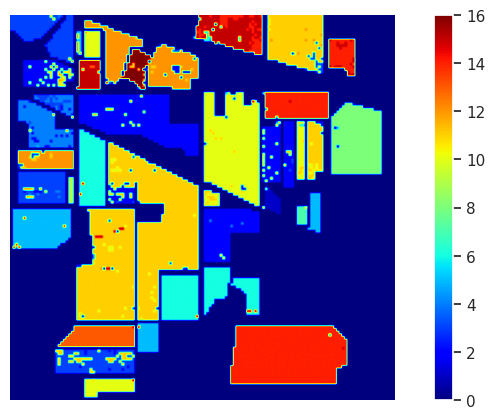

In [30]:
l = []

for i in tqdm(range(df.shape[0])):
    if df.iloc[i, -1] == 0:
        l.append(0)
    else:
        l.append(np.argmax(model.predict(df.iloc[i, :-1].values.reshape(-1, 200)), 1))
    
q = np.array(l).reshape(groundtruth.shape).astype('float')

plot_data(q)